In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


from statsmodels.graphics.gofplots import qqplot
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families.family import Binomial
from statsmodels.api import Logit, GLM

from scipy import stats
import statsmodels.formula.api as smf

##**Задача:**

Для 8416 грибов задано признаковое описание согласно справочнику The Audubon Society Field Guide to North American Mushrooms. Построить модель вероятности ядовитости гриба, оценить вклад факторов.

Рассмотрим данные

In [ ]:
data = pd.read_csv('./mushroom.csv', sep=';')
data

,type,cap shape,cap surface,cap color,bruises,odor,gill attachment,gill spacing,gill size,gill color,...,stalk surface below ring,stalk color above ring,stalk color below ring,veil type,veil color,ring number,ring type,spore print color,population,habitat
0,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
2,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
3,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
4,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8411,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,...,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,BROWN,CLUSTERED,LEAVES
8412,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,...,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,ORANGE,SEVERAL,LEAVES
8413,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,...,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,ORANGE,CLUSTERED,LEAVES
8414,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,...,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,BUFF,SEVERAL,LEAVES


In [ ]:
data.shape

(8416, 23)

Рассмотрим названия признаков и типы их значений для лучшей их интерпретации.

In [ ]:
data.columns

Index(['type', 'cap shape', 'cap surface', 'cap color', 'bruises', 'odor',
       'gill attachment', 'gill spacing', 'gill size', 'gill color',
       'stalk shape', 'stalk root', 'stalk surface above ring',
       'stalk surface below ring', 'stalk color above ring',
       'stalk color below ring', 'veil type', 'veil color', 'ring number',
       'ring type', 'spore print color', 'population', 'habitat'],
      dtype='object')

Целевая переменная - type - бинарный признак.

In [ ]:
data.dtypes

type                        object
cap shape                   object
cap surface                 object
cap color                   object
bruises                     object
odor                        object
gill attachment             object
gill spacing                object
gill size                   object
gill color                  object
stalk shape                 object
stalk root                  object
stalk surface above ring    object
stalk surface below ring    object
stalk color above ring      object
stalk color below ring      object
veil type                   object
veil color                  object
ring number                 object
ring type                   object
spore print color           object
population                  object
habitat                     object
dtype: object

Все признаки представлены в текстовом виде. 

In [ ]:
data.describe()

,type,cap shape,cap surface,cap color,bruises,odor,gill attachment,gill spacing,gill size,gill color,stalk shape,stalk root,stalk surface above ring,stalk surface below ring,stalk color above ring,stalk color below ring,veil type,veil color,ring number,ring type,spore print color,population,habitat
count,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,EDIBLE,CONVEX,SCALY,BROWN,NO,NONE,FREE,CLOSE,BROAD,BUFF,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,WHITE,SEVERAL,WOODS
freq,4488,3796,3268,2320,5040,3808,8200,6824,5880,1728,4864,3800,5316,5076,4744,4640,8416,8216,7768,3968,2424,4064,3160


Все признаки являются дискретными категориальными. Преобразуем их с помощью label encoding.

Рассмотрим гистограммы распределений признаков. Выведем уникальные значения категорий, их порядок соответствует числовой метке.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for column in data.columns:
    print(f'{column}:')
    data[column] = le.fit_transform(data[column]) 
    print(le.classes_)

type:
['EDIBLE' 'POISONOUS']
cap shape:
['BELL' 'CONICAL' 'CONVEX' 'FLAT' 'KNOBBED' 'SUNKEN']
cap surface:
['FIBROUS' 'GROOVES' 'SCALY' 'SMOOTH']
cap color:
['BROWN' 'BUFF' 'CINNAMON' 'GRAY' 'GREEN' 'PINK' 'PURPLE' 'RED' 'WHITE'
 'YELLOW']
bruises:
['BRUISES' 'NO']
odor:
['ALMOND' 'ANISE' 'CREOSOTE' 'FISHY' 'FOUL' 'MUSTY' 'NONE' 'PUNGENT'
 'SPICY']
gill attachment:
['ATTACHED' 'FREE']
gill spacing:
['CLOSE' 'CROWDED']
gill size:
['BROAD' 'NARROW']
gill color:
['BLACK' 'BROWN' 'BUFF' 'CHOCOLATE' 'GRAY' 'GREEN' 'ORANGE' 'PINK'
 'PURPLE' 'RED' 'WHITE' 'YELLOW']
stalk shape:
['ENLARGING' 'TAPERING']
stalk root:
['?' 'BULBOUS' 'CLUB' 'EQUAL' 'ROOTED']
stalk surface above ring:
['FIBROUS' 'SCALY' 'SILKY' 'SMOOTH']
stalk surface below ring:
['FIBROUS' 'SCALY' 'SILKY' 'SMOOTH']
stalk color above ring:
['BROWN' 'BUFF' 'CINNAMON' 'GRAY' 'ORANGE' 'PINK' 'RED' 'WHITE' 'YELLOW']
stalk color below ring:
['BROWN' 'BUFF' 'CINNAMON' 'GRAY' 'ORANGE' 'PINK' 'RED' 'WHITE' 'YELLOW']
veil type:
['PARTIAL']


В столбце stalk root есть пропуски (значение '?', кодирующееся нулем после label encoding). Заполним пропуски медианой по столбцу.

In [ ]:
data['stalk root'].value_counts()

1    3800
0    2480
3    1376
2     568
4     192
Name: stalk root, dtype: int64

In [ ]:
data['stalk root'][data['stalk root'] == 0] = np.nan
data.fillna(data['stalk root'].median(), inplace=True)
data

,type,cap shape,cap surface,cap color,bruises,odor,gill attachment,gill spacing,gill size,gill color,...,stalk surface below ring,stalk color above ring,stalk color below ring,veil type,veil color,ring number,ring type,spore print color,population,habitat
0,0,2,3,8,0,0,1,1,1,10,...,3,7,7,0,2,1,4,6,4,6
1,0,2,3,8,0,0,1,1,1,10,...,3,7,7,0,2,1,4,1,4,6
2,0,2,3,8,0,0,1,1,1,7,...,3,7,7,0,2,1,4,6,4,6
3,0,2,3,8,0,0,1,1,1,7,...,3,7,7,0,2,1,4,1,4,6
4,0,2,3,8,0,0,1,1,1,1,...,3,7,7,0,2,1,4,6,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8411,0,4,3,0,1,6,0,0,0,1,...,3,4,4,0,0,1,4,1,1,1
8412,0,4,3,0,1,6,0,0,0,1,...,3,4,4,0,0,1,4,5,4,1
8413,0,4,3,0,1,6,0,0,0,1,...,3,4,4,0,0,1,4,5,1,1
8414,0,4,3,0,1,6,0,0,0,1,...,3,4,4,0,0,1,4,2,4,1


Рассмотрим распределения признаков. Таблицы сопряженности будет анализировать затруднительно, много категориальных признаков с большим числом значений, поэтому рассмотрим гистограммы распределений признаков.

array([[<Axes: title={'center': 'type'}>,
        <Axes: title={'center': 'cap shape'}>,
        <Axes: title={'center': 'cap surface'}>,
        <Axes: title={'center': 'cap color'}>,
        <Axes: title={'center': 'bruises'}>],
       [<Axes: title={'center': 'odor'}>,
        <Axes: title={'center': 'gill attachment'}>,
        <Axes: title={'center': 'gill spacing'}>,
        <Axes: title={'center': 'gill size'}>,
        <Axes: title={'center': 'gill color'}>],
       [<Axes: title={'center': 'stalk shape'}>,
        <Axes: title={'center': 'stalk root'}>,
        <Axes: title={'center': 'stalk surface above ring'}>,
        <Axes: title={'center': 'stalk surface below ring'}>,
        <Axes: title={'center': 'stalk color above ring'}>],
       [<Axes: title={'center': 'stalk color below ring'}>,
        <Axes: title={'center': 'veil type'}>,
        <Axes: title={'center': 'veil color'}>,
        <Axes: title={'center': 'ring number'}>,
        <Axes: title={'center': 'ring type

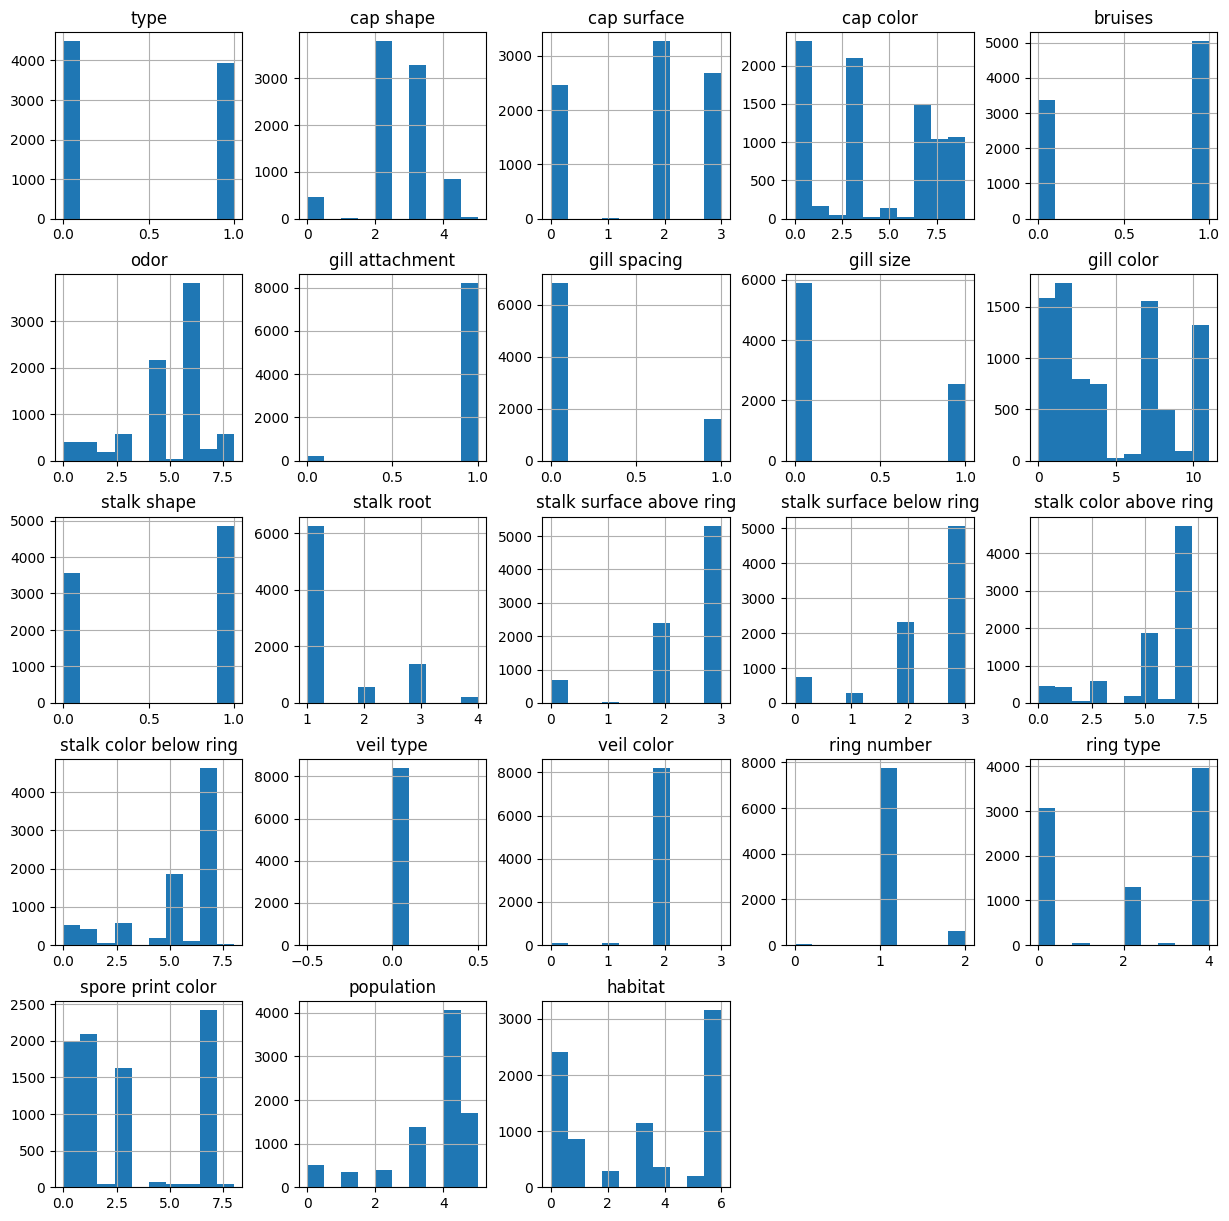

In [ ]:
data.hist(figsize=(15, 15))

Явных выбросов не замечено, есть просто относительно редкие категории.

Можем построить более детализированные и красивые графики из seaborn.

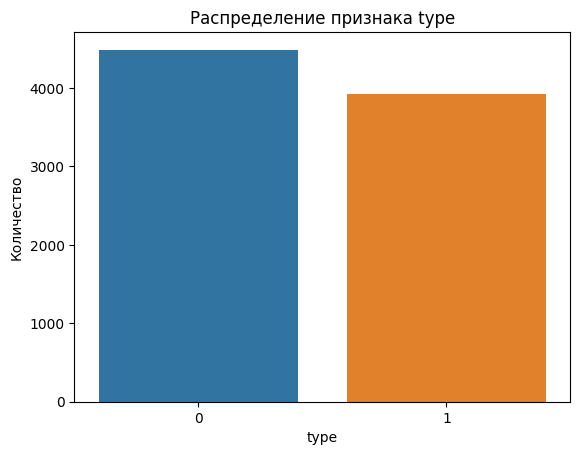

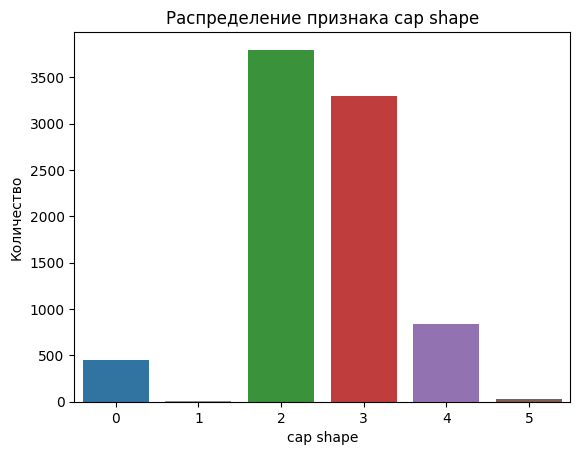

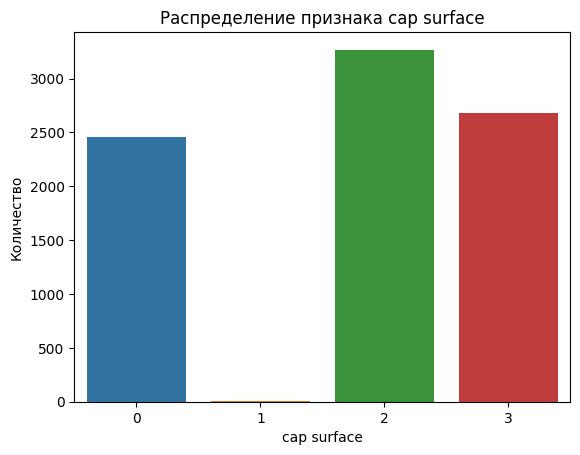

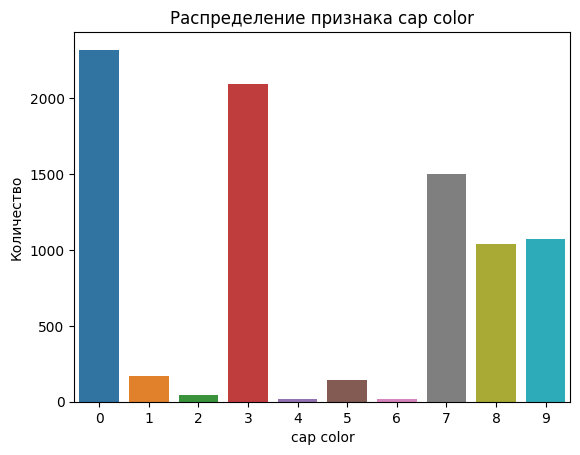

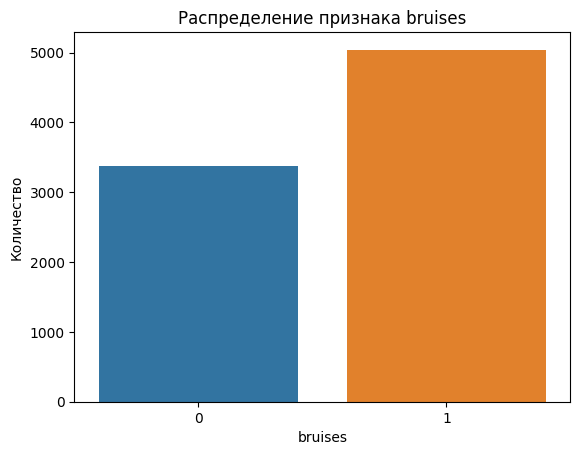

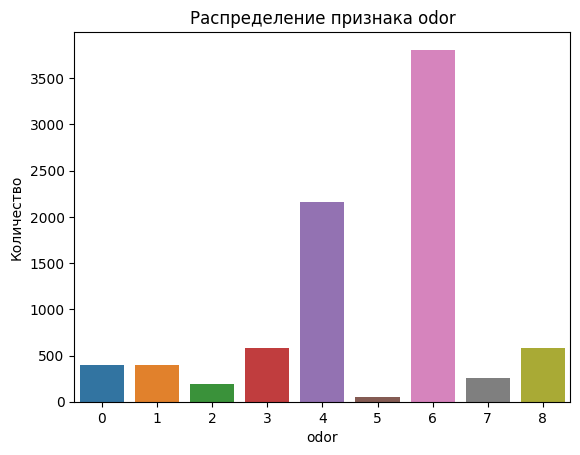

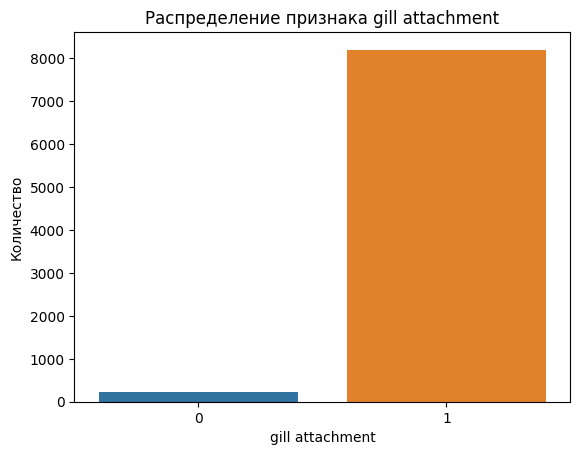

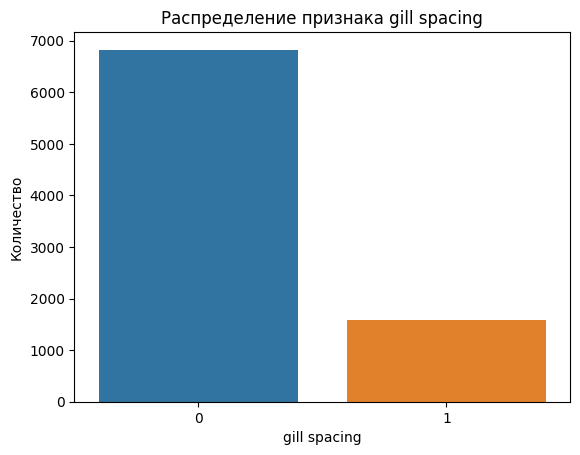

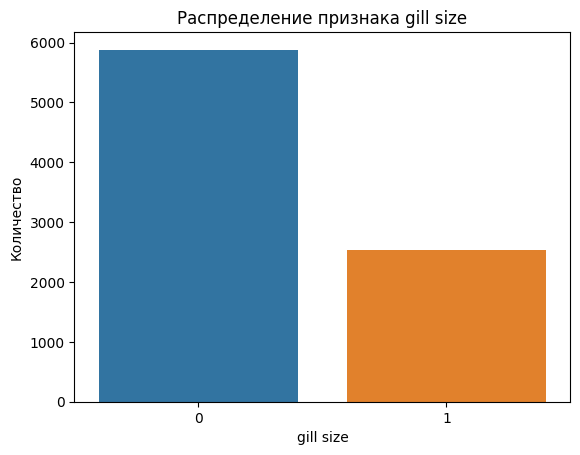

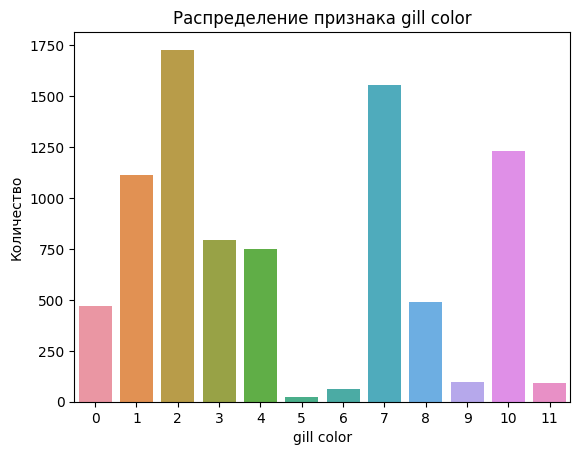

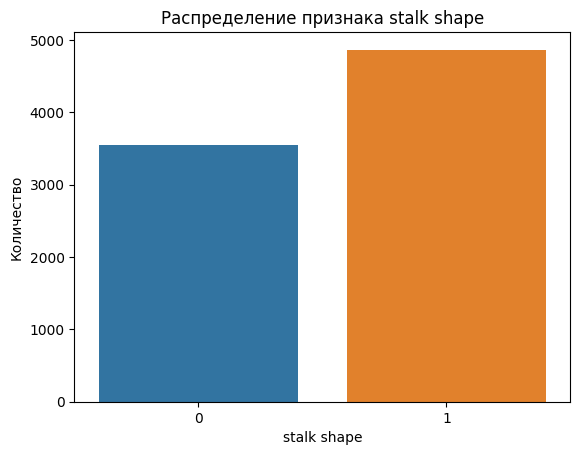

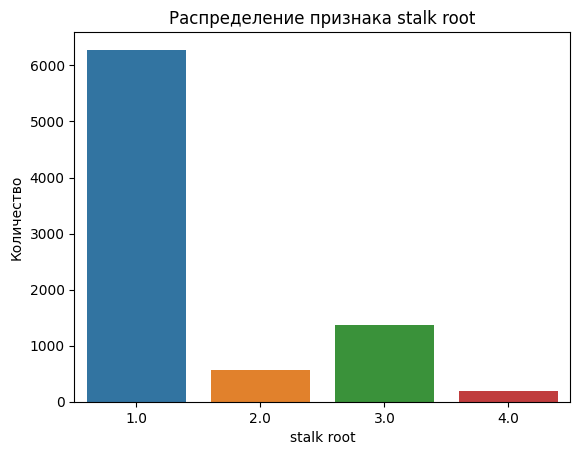

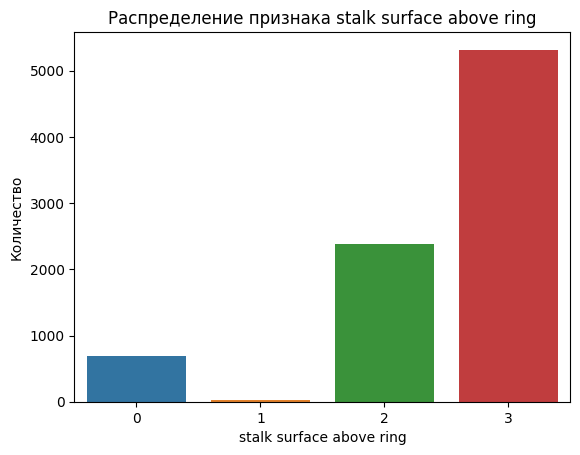

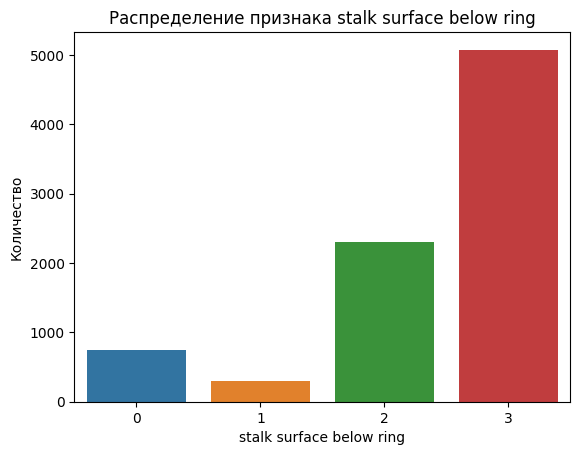

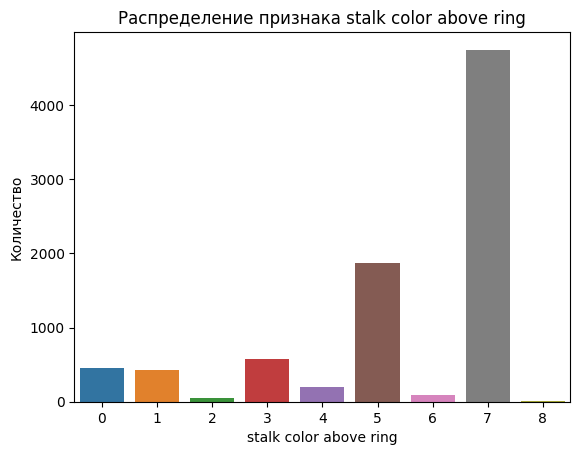

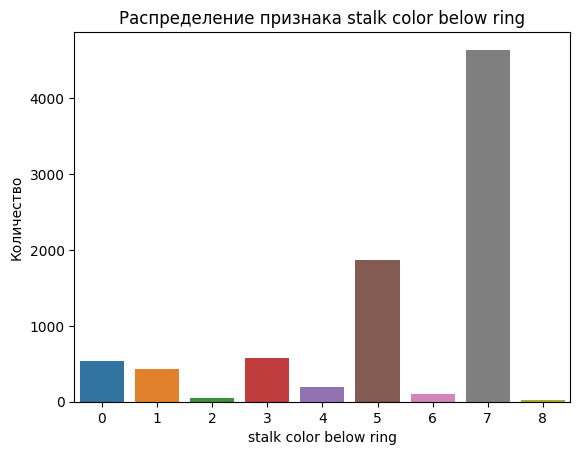

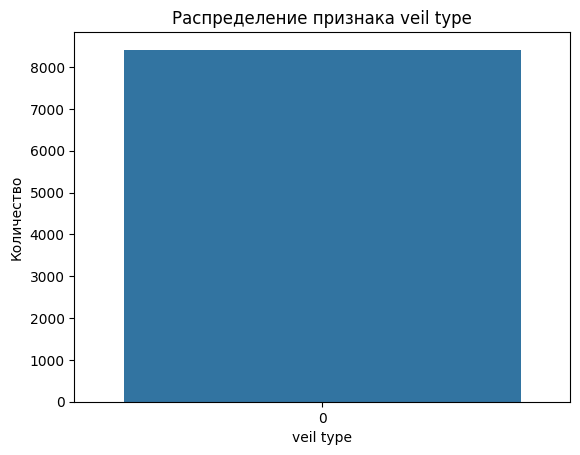

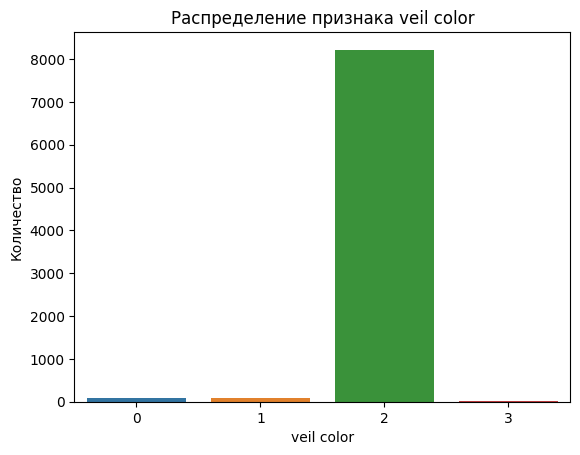

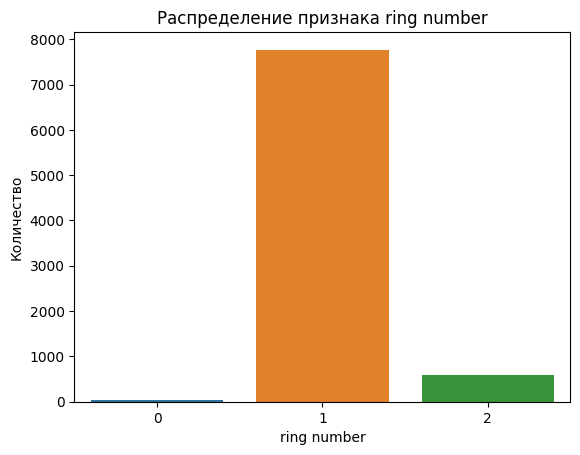

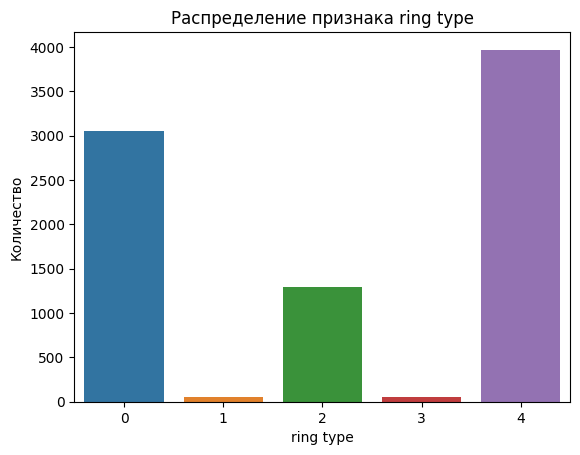

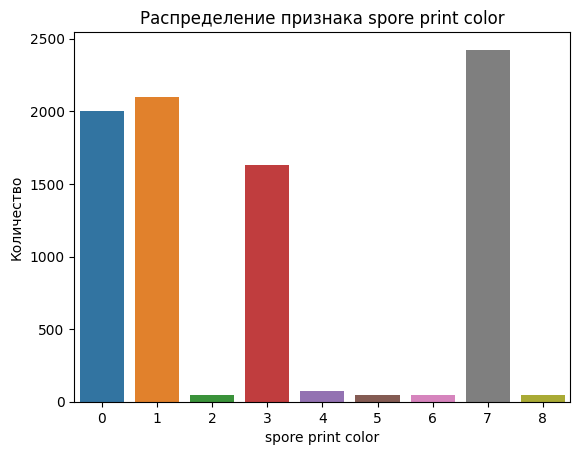

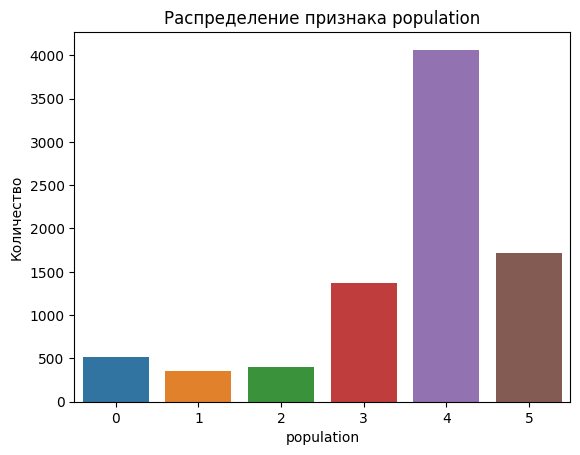

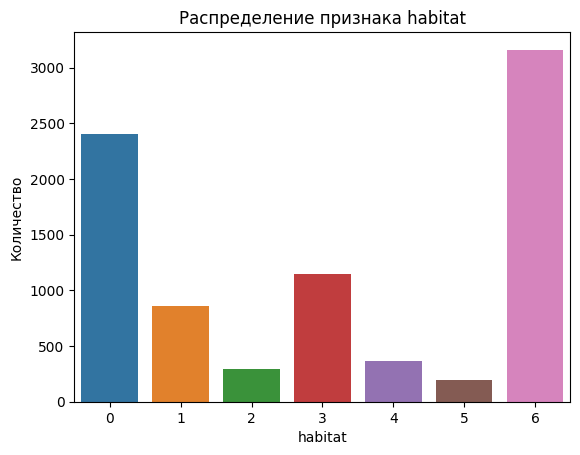

In [ ]:
for column in data.columns:
    plt.figure()
    cp = sns.countplot(x=column, data=data)
    cp.set_title(f'Распределение признака {column}');
    cp.set_ylabel('Количество')
    plt.show()

Пока что сказать что-то конкретное довольно сложно, в разных признаках наблюдается разное соотношение между значениями категорий. Грибов каждого из видов (съедобный/ядовитый) примерно поровну. Выбросов явно тоже не заметно, однако присутствуют редкие категории. Также признак veil type для все объектов одинаковый, следовательно, можем удалить его как неинформативный.

In [ ]:
data.drop(['veil type'], axis=1, inplace=True)

Рассмотрим попарные распределения признаков.

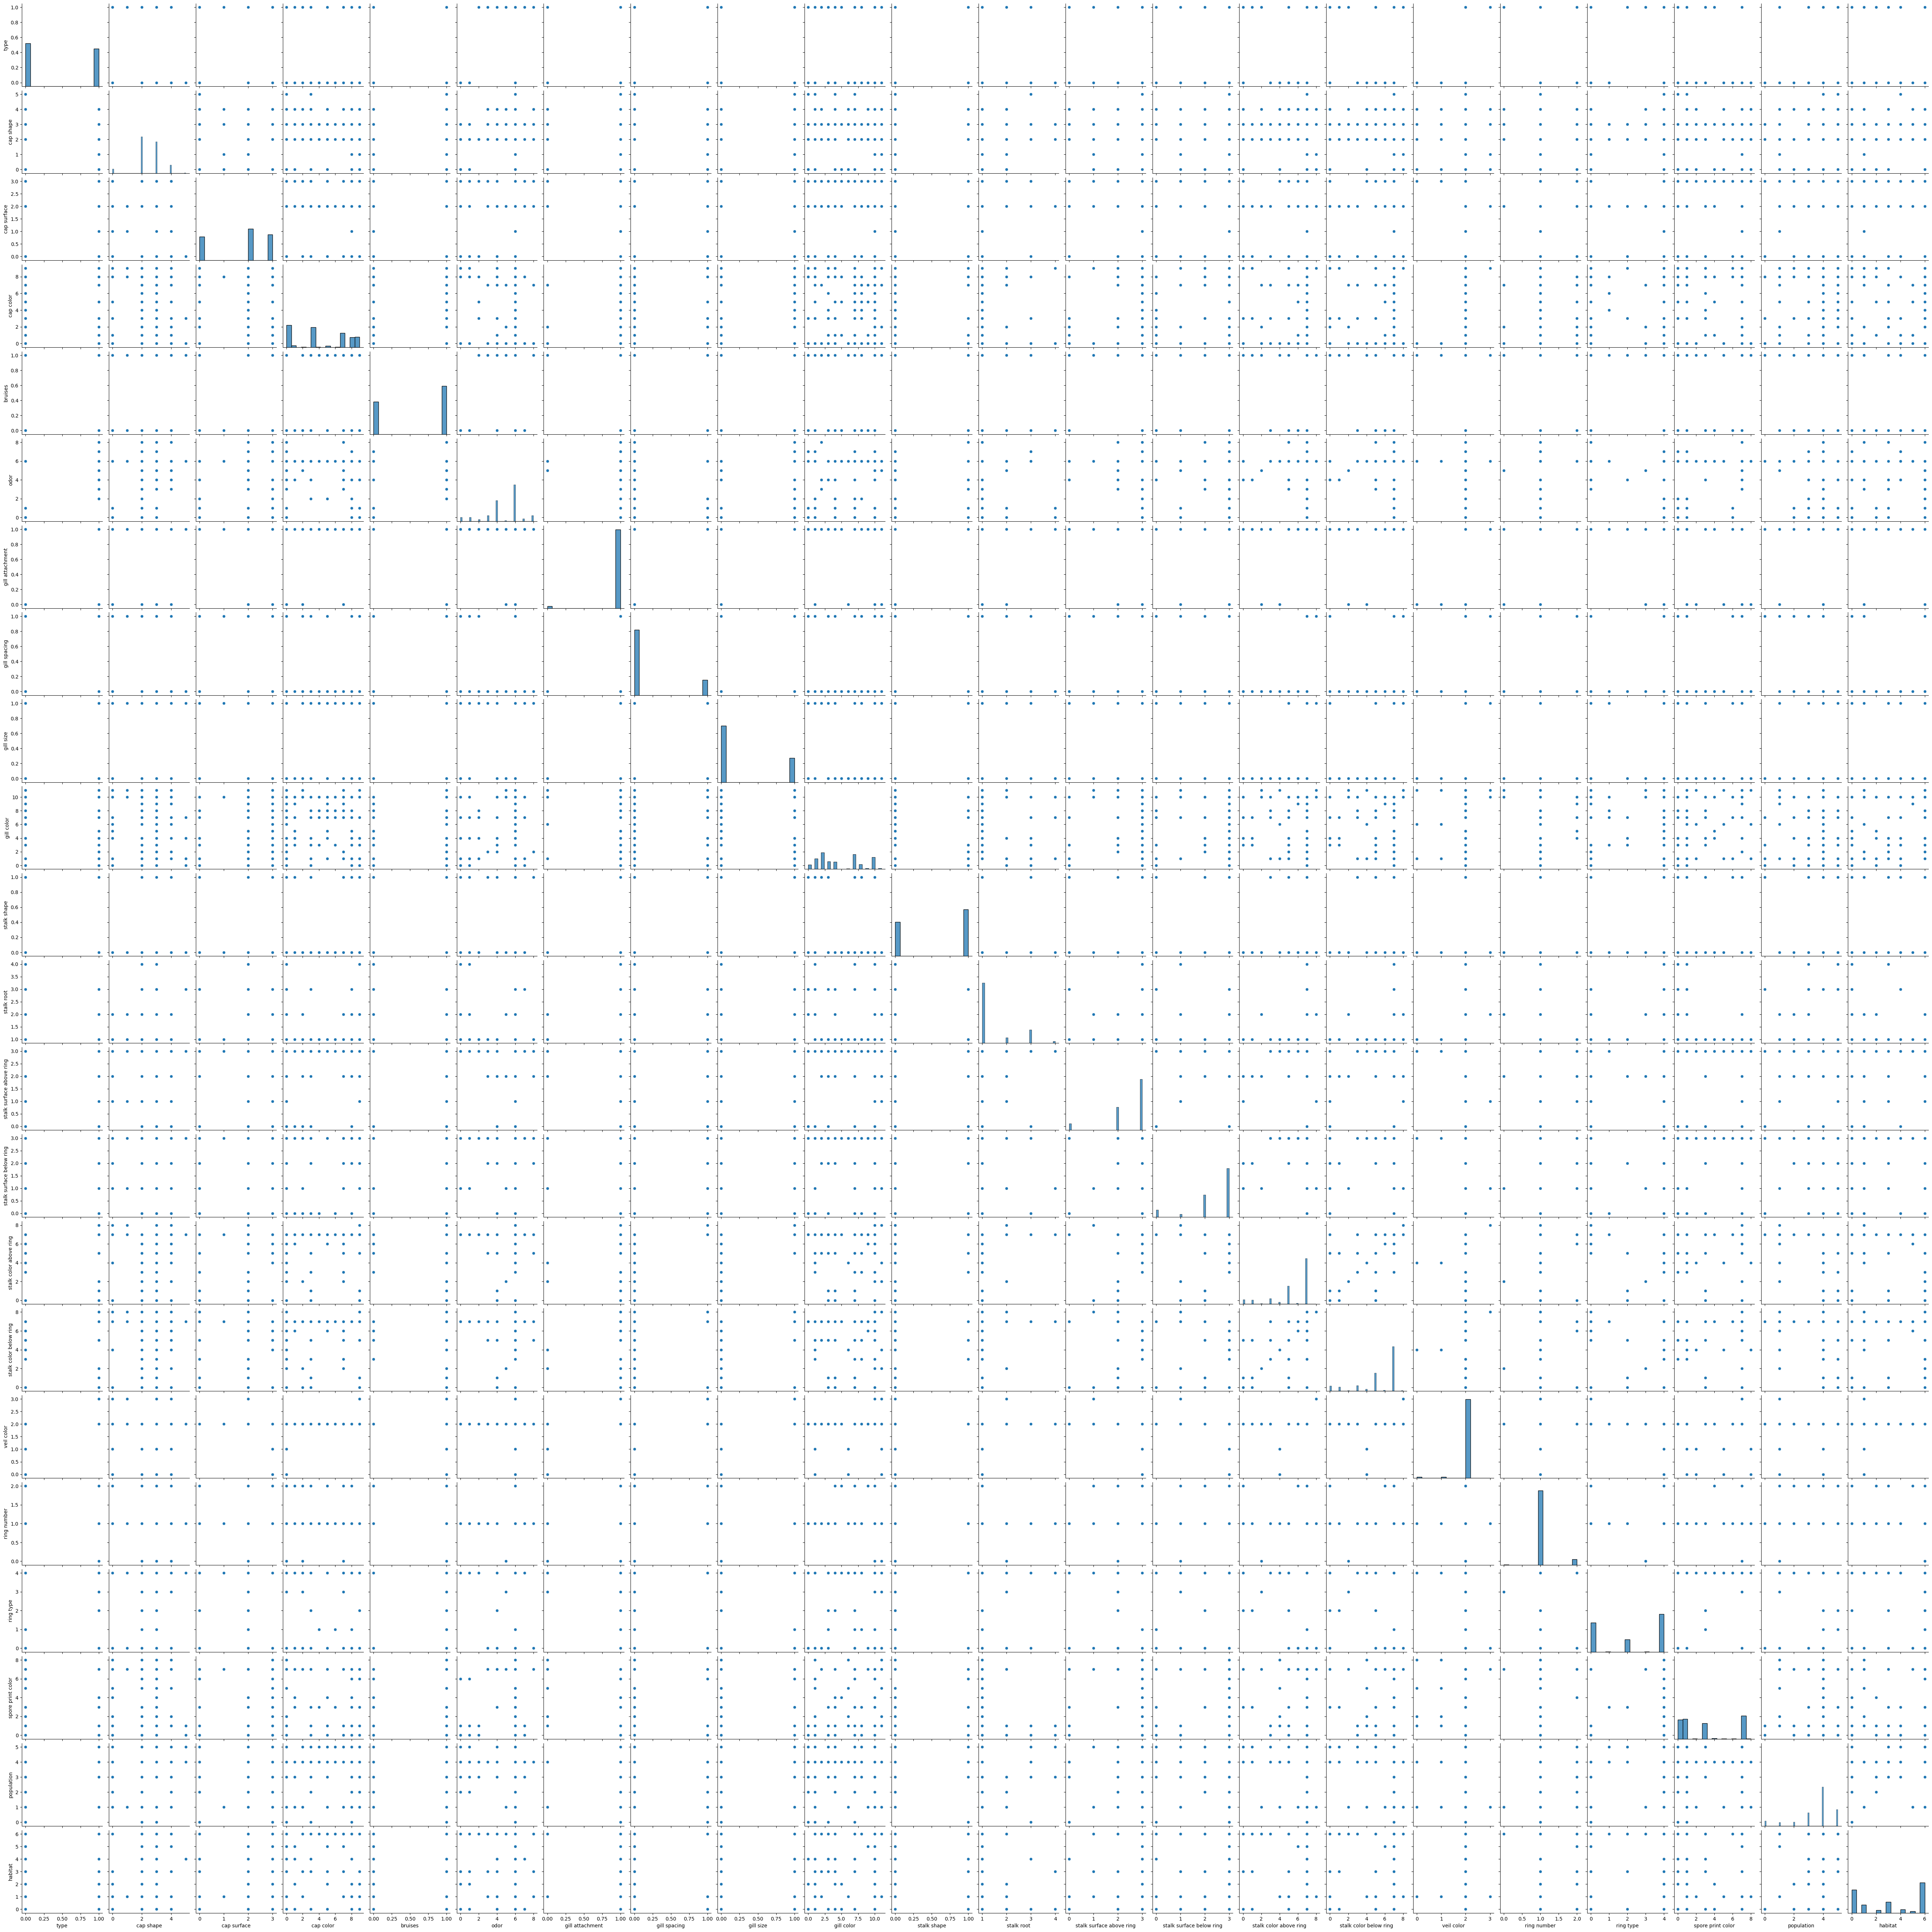

In [ ]:
sns.pairplot(data)

Рассмотрим распределение признаков в зависимости от класса гриба.

<ipython-input-65-0b5bd204cf40>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


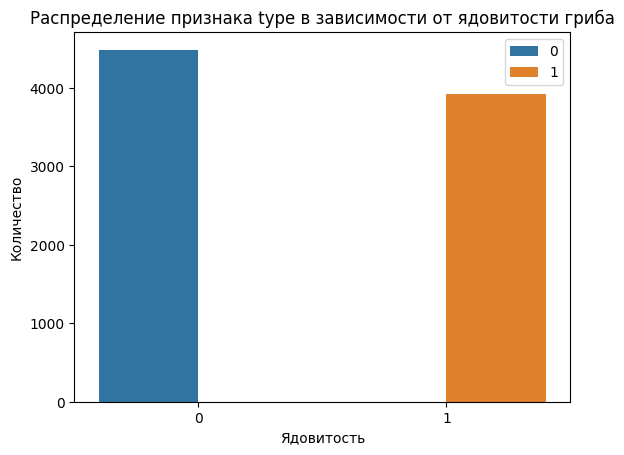

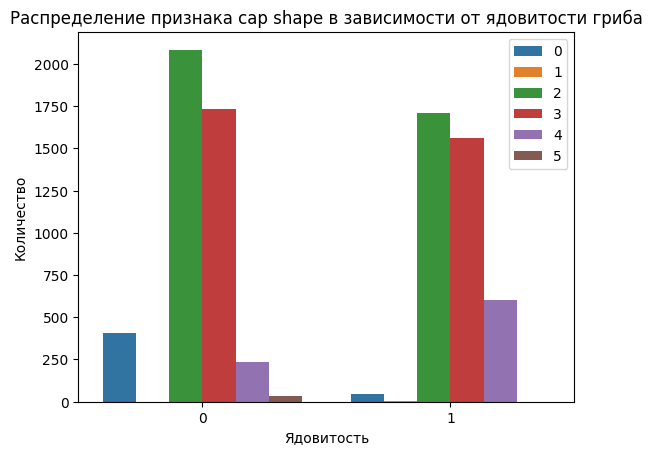

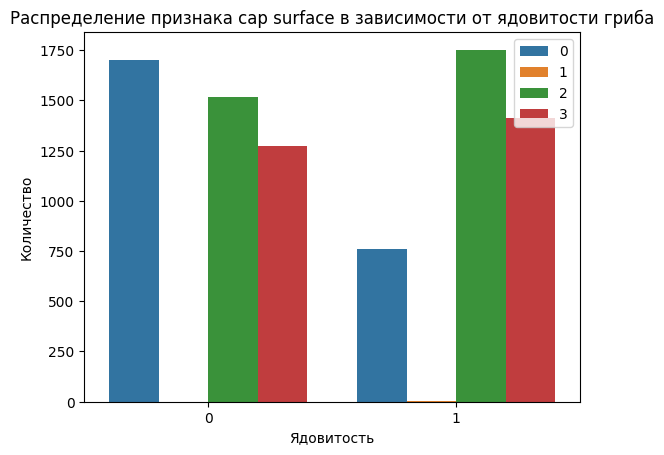

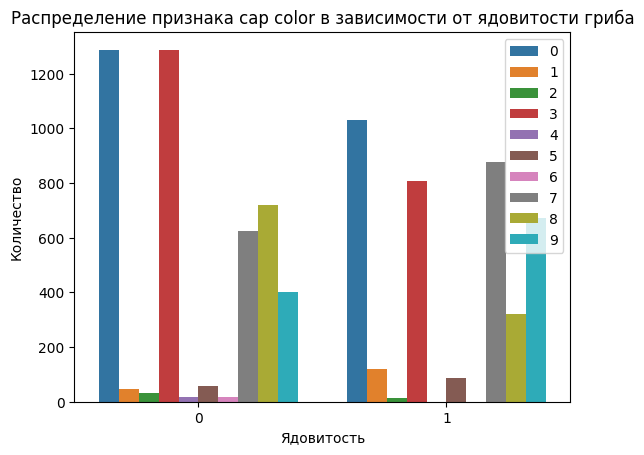

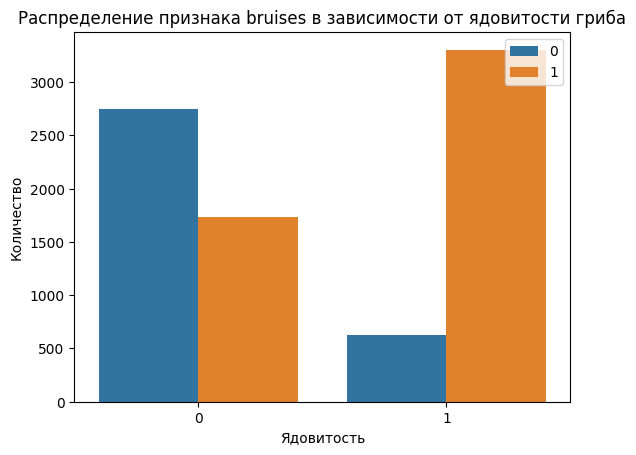

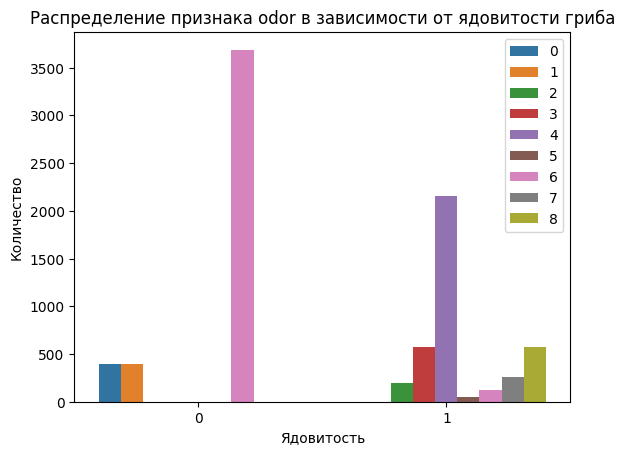

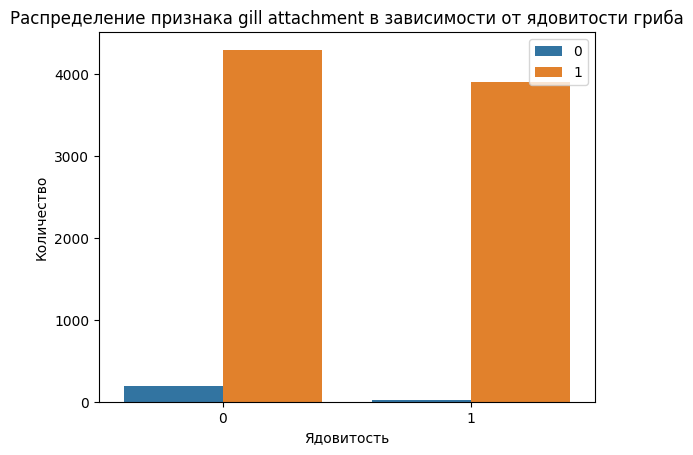

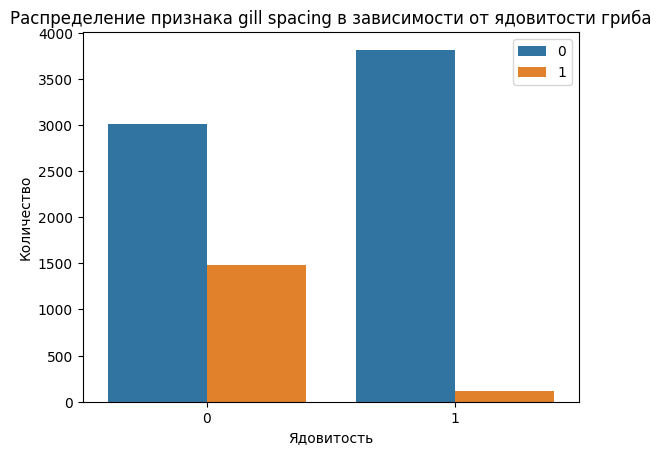

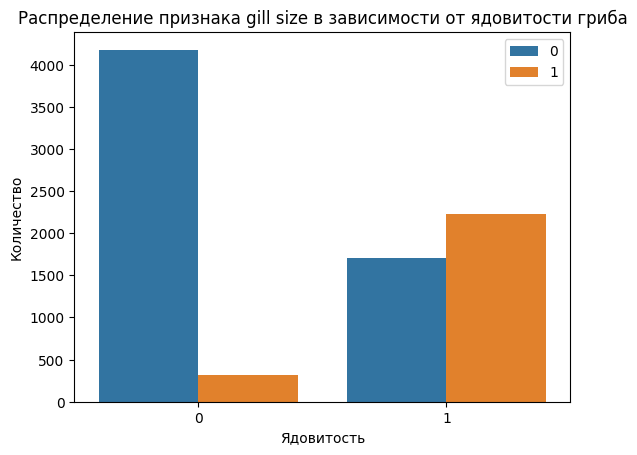

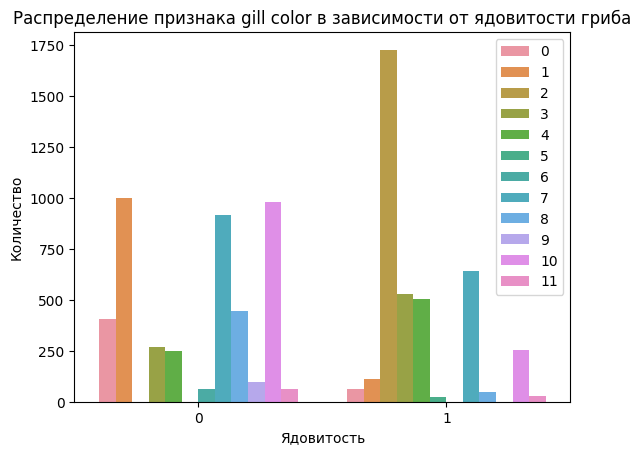

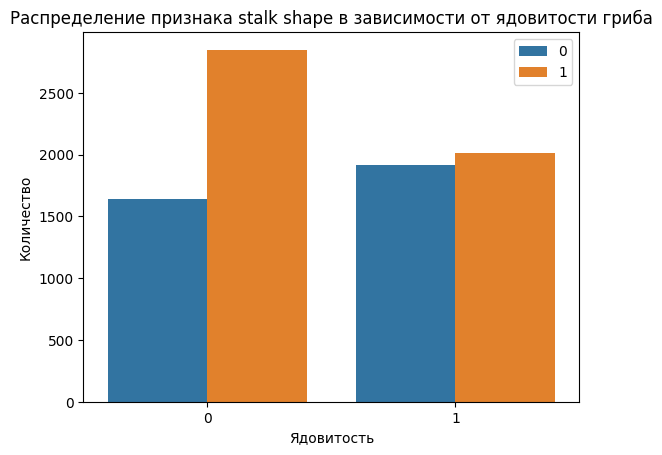

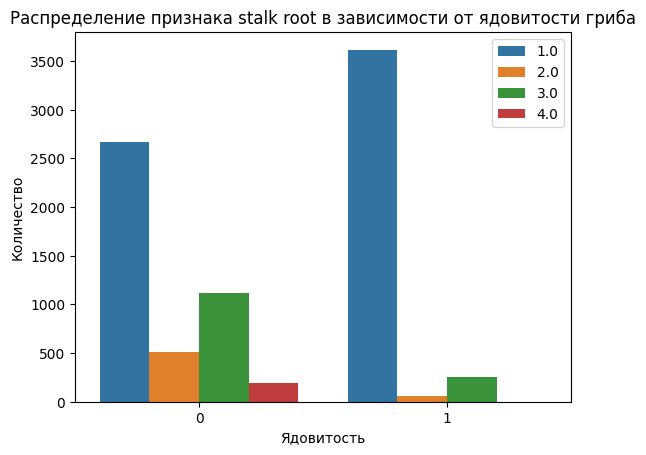

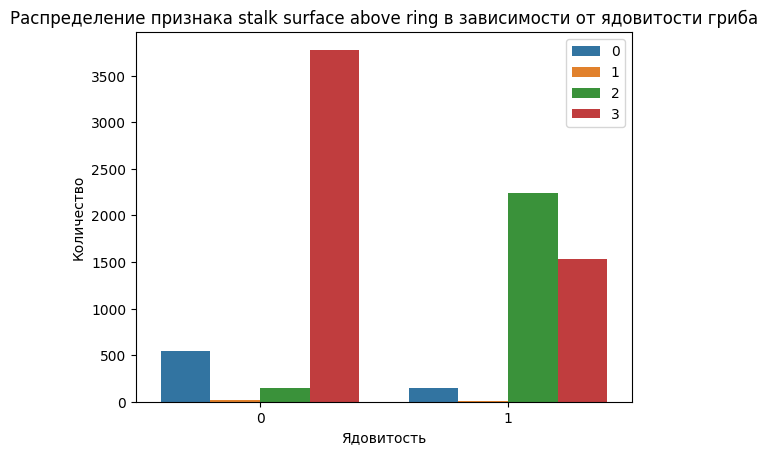

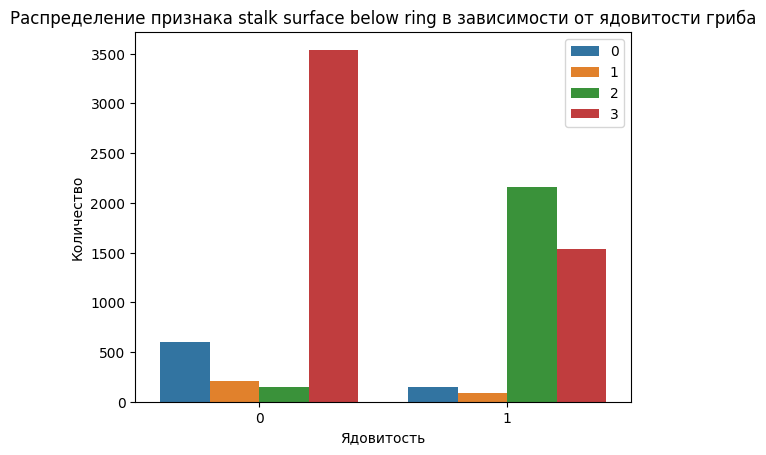

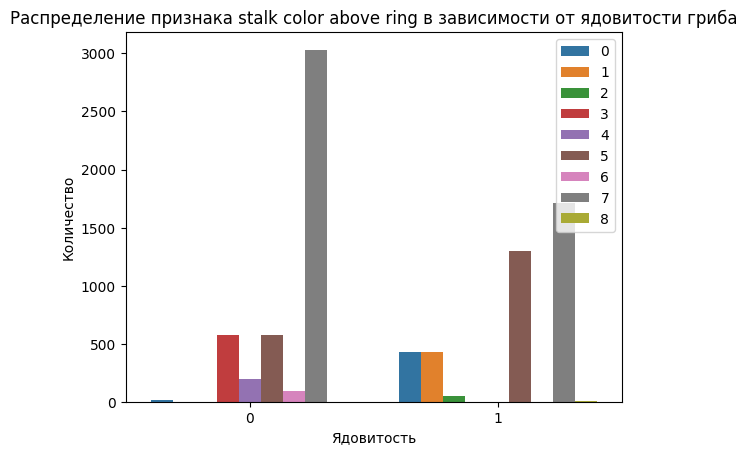

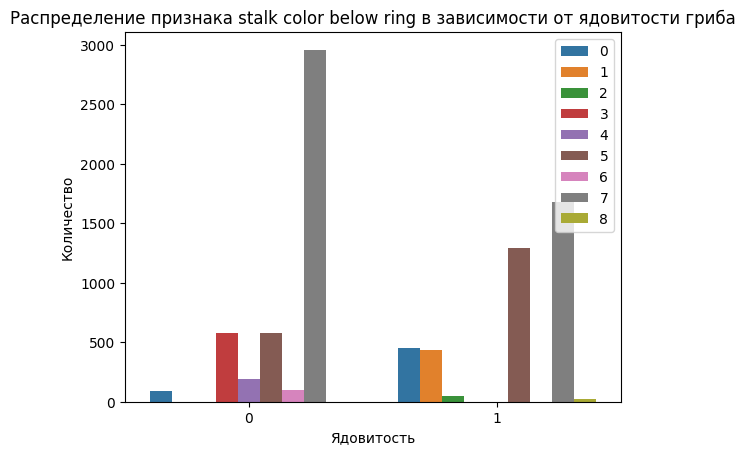

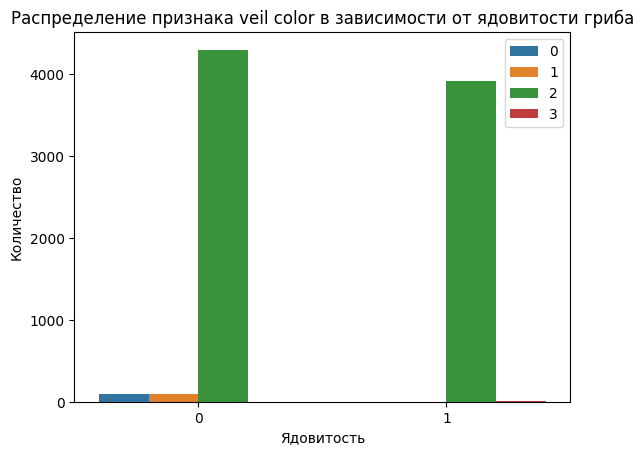

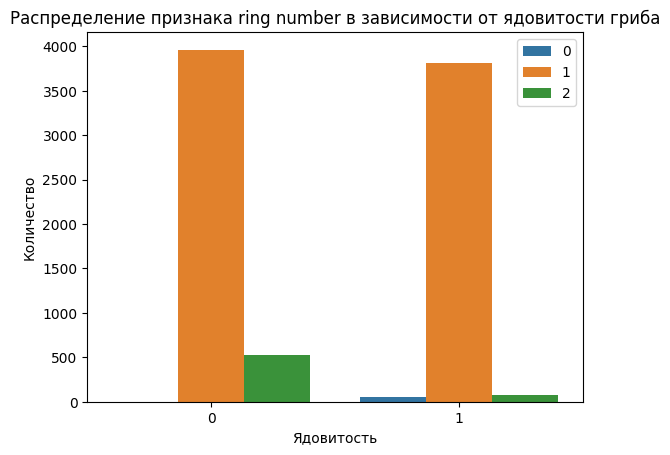

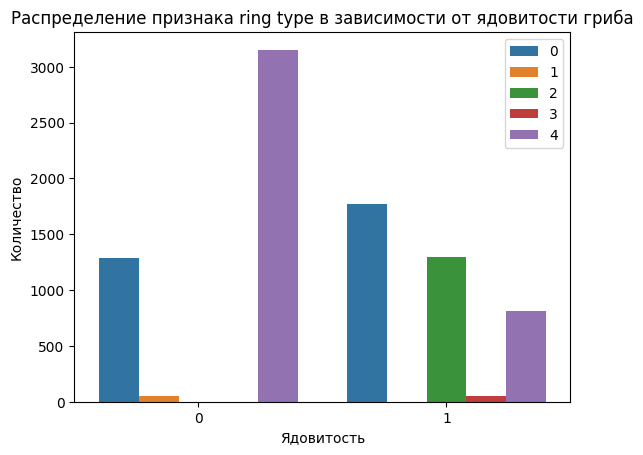

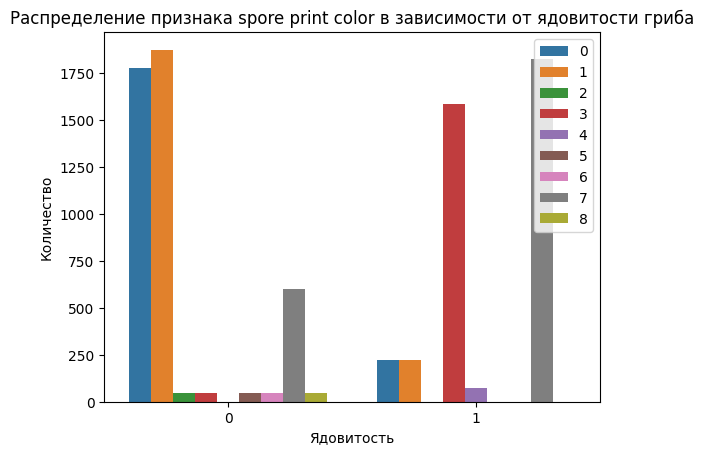

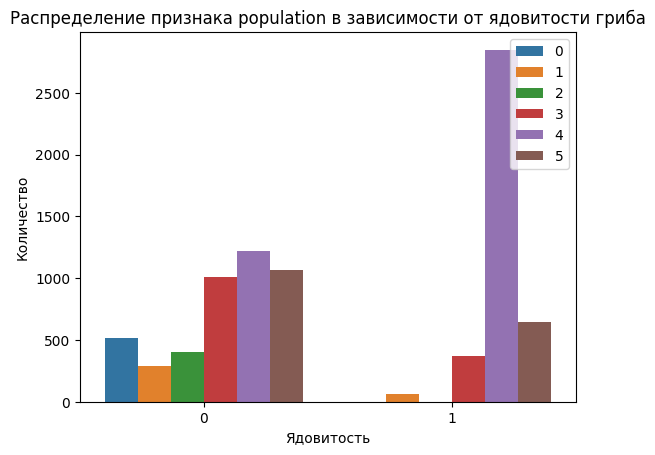

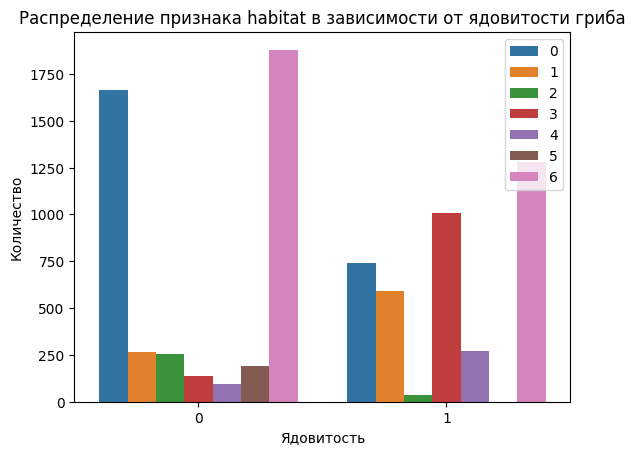

In [ ]:
for column in data.columns:
    plt.figure()
    cp = sns.countplot(x='type', hue=column, data=data)
    cp.set_ylabel('Количество')
    cp.set_xlabel('Ядовитость')
    cp.set_title(f'Распределение признака {column} в зависимости от ядовитости гриба');
    cp.legend(loc='upper right')

В целом распределения признаков в зависимости от класса гриба различаются, хотя в некоторых случаях значения признаков распределены достаточно похожим образом. Таким образом, можно сказать, что все оставленные признаки хоть сколь-нибудь информативны, их нельзя считать шумовыми и отбрасывать при рассмотрении. Однако потенциальными "кандидатами" на неинформативность можно назвать признаки gill attachment, veil color и veil type, для них распределения для разных классов довольно похожи, или же в них присутствует по сути только одна категория.

Рассмотрим попарные корреляции между признаками. Используем коэффициент V Крамера.

In [ ]:
from scipy.stats import chi2_contingency
import numpy as np




def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
  stat = chi2_contingency(crosstab)[0] 
  obs = np.sum(crosstab) 
  mini = min(crosstab.shape)-1 
  return (stat/(obs*mini))


rows= []

for var1 in data:
  col = []
  for var2 in data :
    cramers =cramers_V(data[var1], data[var2]) 
    col.append(round(cramers,2))   
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data.columns, index =data.columns)

<Axes: >

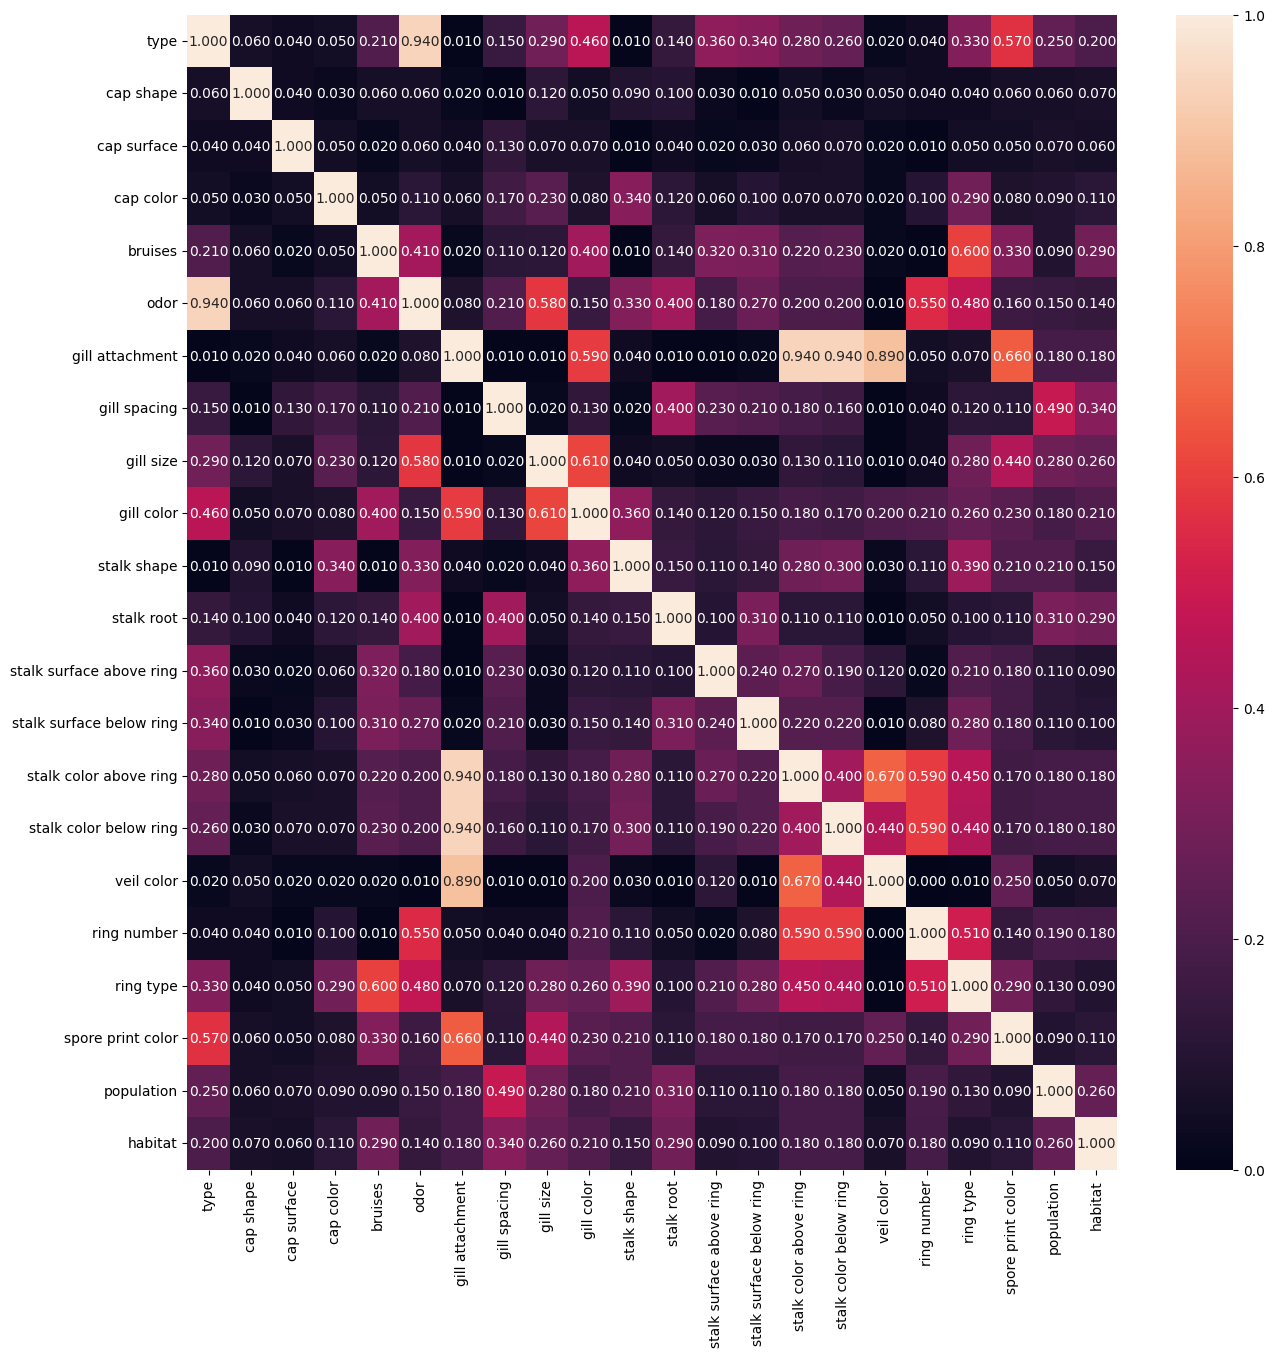

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df, annot=True, fmt='0.3f')

Присутствуют признаки, имеющие почти нулевое значение коэффициентов корреляции с меткой класса, что говорит практически о полном отсутствии взаимосвязи с целевой переменной, например, gill attachment. Также заметны очень сильно скоррелированные с признаком gill attachment признаки stalk color above ring, stalk color below ring, veil color, однако друг с другом они слабо взаимодействуют. Таким образом, можем удалить также и признак gill attachment.

In [ ]:
data.drop(['gill attachment'], axis=1, inplace=True)

Также имеем признак odor, имеющий почти единичное значение коэффициента, что говорит о тесной этого признака с целевым. Возможно он является ключевым признаком для определения ядовитости гриба.

Для построения модели вероятности ядовитости используем логистическую регрессию. Так как признаки категориальны, предварительно преобразуем их с помощью one-hot encoding.


In [ ]:
columns = data.columns
columns = columns[1:]
for column in columns:
    data = data.join(pd.get_dummies(data[column], prefix=column, drop_first=True))
    data.drop(columns=column, inplace=True)

data

,type,cap shape_1,cap shape_2,cap shape_3,cap shape_4,cap shape_5,cap surface_1,cap surface_2,cap surface_3,cap color_1,...,population_2,population_3,population_4,population_5,habitat_1,habitat_2,habitat_3,habitat_4,habitat_5,habitat_6
0,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8411,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
8412,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
8413,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
8414,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0


Рассмотрим корреляции Мэттьюса для бинаризованных признаков.

In [ ]:
from itertools import combinations
from collections import defaultdict

def apply_pair_statistics(S, pair_statistics, statistics_names):
    res = defaultdict(list)

    for i, j in combinations(range(S.shape[1]), 2):
        x_name, y_name = f'X{i+1}', f'X{j+1}'
        x, y = S.T[i], S.T[j]
        res["Pair"].append(x_name + ' - ' + y_name)
        for statistic, name in zip(pair_statistics, statistics_names):
            res[name].append(statistic(x, y))

    res = pd.DataFrame(res)
    return res

In [ ]:
def phi(x_bin, y_bin):
    n11 = (x_bin & y_bin).sum()
    n10 = (x_bin & ~y_bin).sum()
    n01 = (~x_bin & y_bin).sum()
    n00 = (~x_bin & ~y_bin).sum()

    return (n11 * n00 - n10 * n01) / np.sqrt((n11 + n10) * (n01 + n00) * (n11 + n01) * (n10 + n00))

In [ ]:
res = apply_pair_statistics(data, [phi], ['Phi'])

In [ ]:
res

,Pair,Phi
0,X1 - X2,-0.950185
1,X1 - X3,-0.950185
2,X1 - X4,-0.900371
3,X1 - X5,-0.950185
4,X1 - X6,-0.900371
...,...,...
4366,X91 - X93,-0.950185
4367,X91 - X94,-0.900371
4368,X92 - X93,-0.900371
4369,X92 - X94,-0.950185


In [ ]:
res['Phi'].min()

-0.9761930920432458

In [ ]:
res['Phi'].mean()

-0.8659103193833027

In [ ]:
res['Phi'].max()

-0.7509273979862215

Обучим логистическую регрессиию.

In [ ]:
X = data.drop(['type'], axis=1)
y = data['type']

Рассмотрим логистическую регрессию из statsmodels для более подробного выведения результатов.

In [ ]:
model = Logit(y, X)
result = model.fit()
result.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.9/dist-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35


LinAlgError: ignored

In [ ]:
model = GLM(y, X, family=Binomial())
result = model.fit()
result.summary()

PerfectSeparationError: ignored

Получили ошибку PerfectSeparationError, согласно [документации](https://www.perplexity.ai/search/022dd187-ef87-4e95-a4d5-8cdabc87372a?s=c), это означает, что целевая переменная идеально предсказывается по предикторам, т. е. по некторым признакам выборка идеально разбивается, и логистическая регрессия не может обучитсья из-за этого. Она начинает переобучаться, у нее появляется возможность выставлять значения вероятностей почти в 1 или 0 путем выкручивания коэффициентов, возникает сильное переобучение и потеря обобщающей способности. Судя по всему, таким идеальным предсказателем является признак odor, судя по значениям коэффициентов V Крамера. Также согласно документации, исправить эту ситуацию можно удалением высокоскоррелированных с меткой класса переменных, или использованием других моделей. Попробуем рассмотреть каждый из способов, а также попробуем обучить логистичекую регрессию с оставленным признаком odor, но возможно удаленными остальными, чтобы получилась невырожденная матрица. 

In [ ]:
from numpy.linalg import matrix_rank
matrix_rank(X)

85

In [ ]:
X.shape

(8416, 93)

Матрица признаков действительно вырождена, причем по признакам. Также судя по всему наблюдения обоих классов линейно разделимы в пространстве признаков. 

Попробуем обучить модель с L1 регуляризацией.


In [ ]:
model = Logit(y, X)
result = model.fit_regularized()
result.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1169199030503365e-10
            Iterations: 100
            Function evaluations: 100
            Gradient evaluations: 100


LinAlgError: ignored

Не помогло, попробуем регуляризацию Фирта. Параметры теперь по идее не должны так сильно выкручиваться из-за оптимизации дополнительно логарифма информации Фишера.

In [ ]:
!pip install firthlogist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 10.1 MB/s eta 0:00:00


In [ ]:
from firthlogist import FirthLogisticRegression
fl = FirthLogisticRegression()
fl.fit(X, y)
fl.summary(xname=X.columns)

/usr/local/lib/python3.9/dist-packages/firthlogist/firthlogist.py:322: RuntimeWarning: divide by zero encountered in log
  penalty = 0.5 * np.log(np.linalg.det(fisher_info_mtx))
/usr/local/lib/python3.9/dist-packages/firthlogist/firthlogist.py:322: RuntimeWarning: invalid value encountered in log
  penalty = 0.5 * np.log(np.linalg.det(fisher_info_mtx))
/usr/local/lib/python3.9/dist-packages/firthlogist/firthlogist.py:153: ConvergenceWarning: Firth logistic regression failed to converge. Try increasing max_iter.
  self.coef_, self.loglik_, self.n_iter_ = _firth_newton_raphson(
/usr/local/lib/python3.9/dist-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


LinAlgError: ignored

Таким образом, использование регуляризованных моделей не позволяет обойти проблему.

Попробуем получить невырожденную матрицу, оставив признак odor.

Рассмотрим корреляции уже для бинаризованных признаков.

<Axes: >

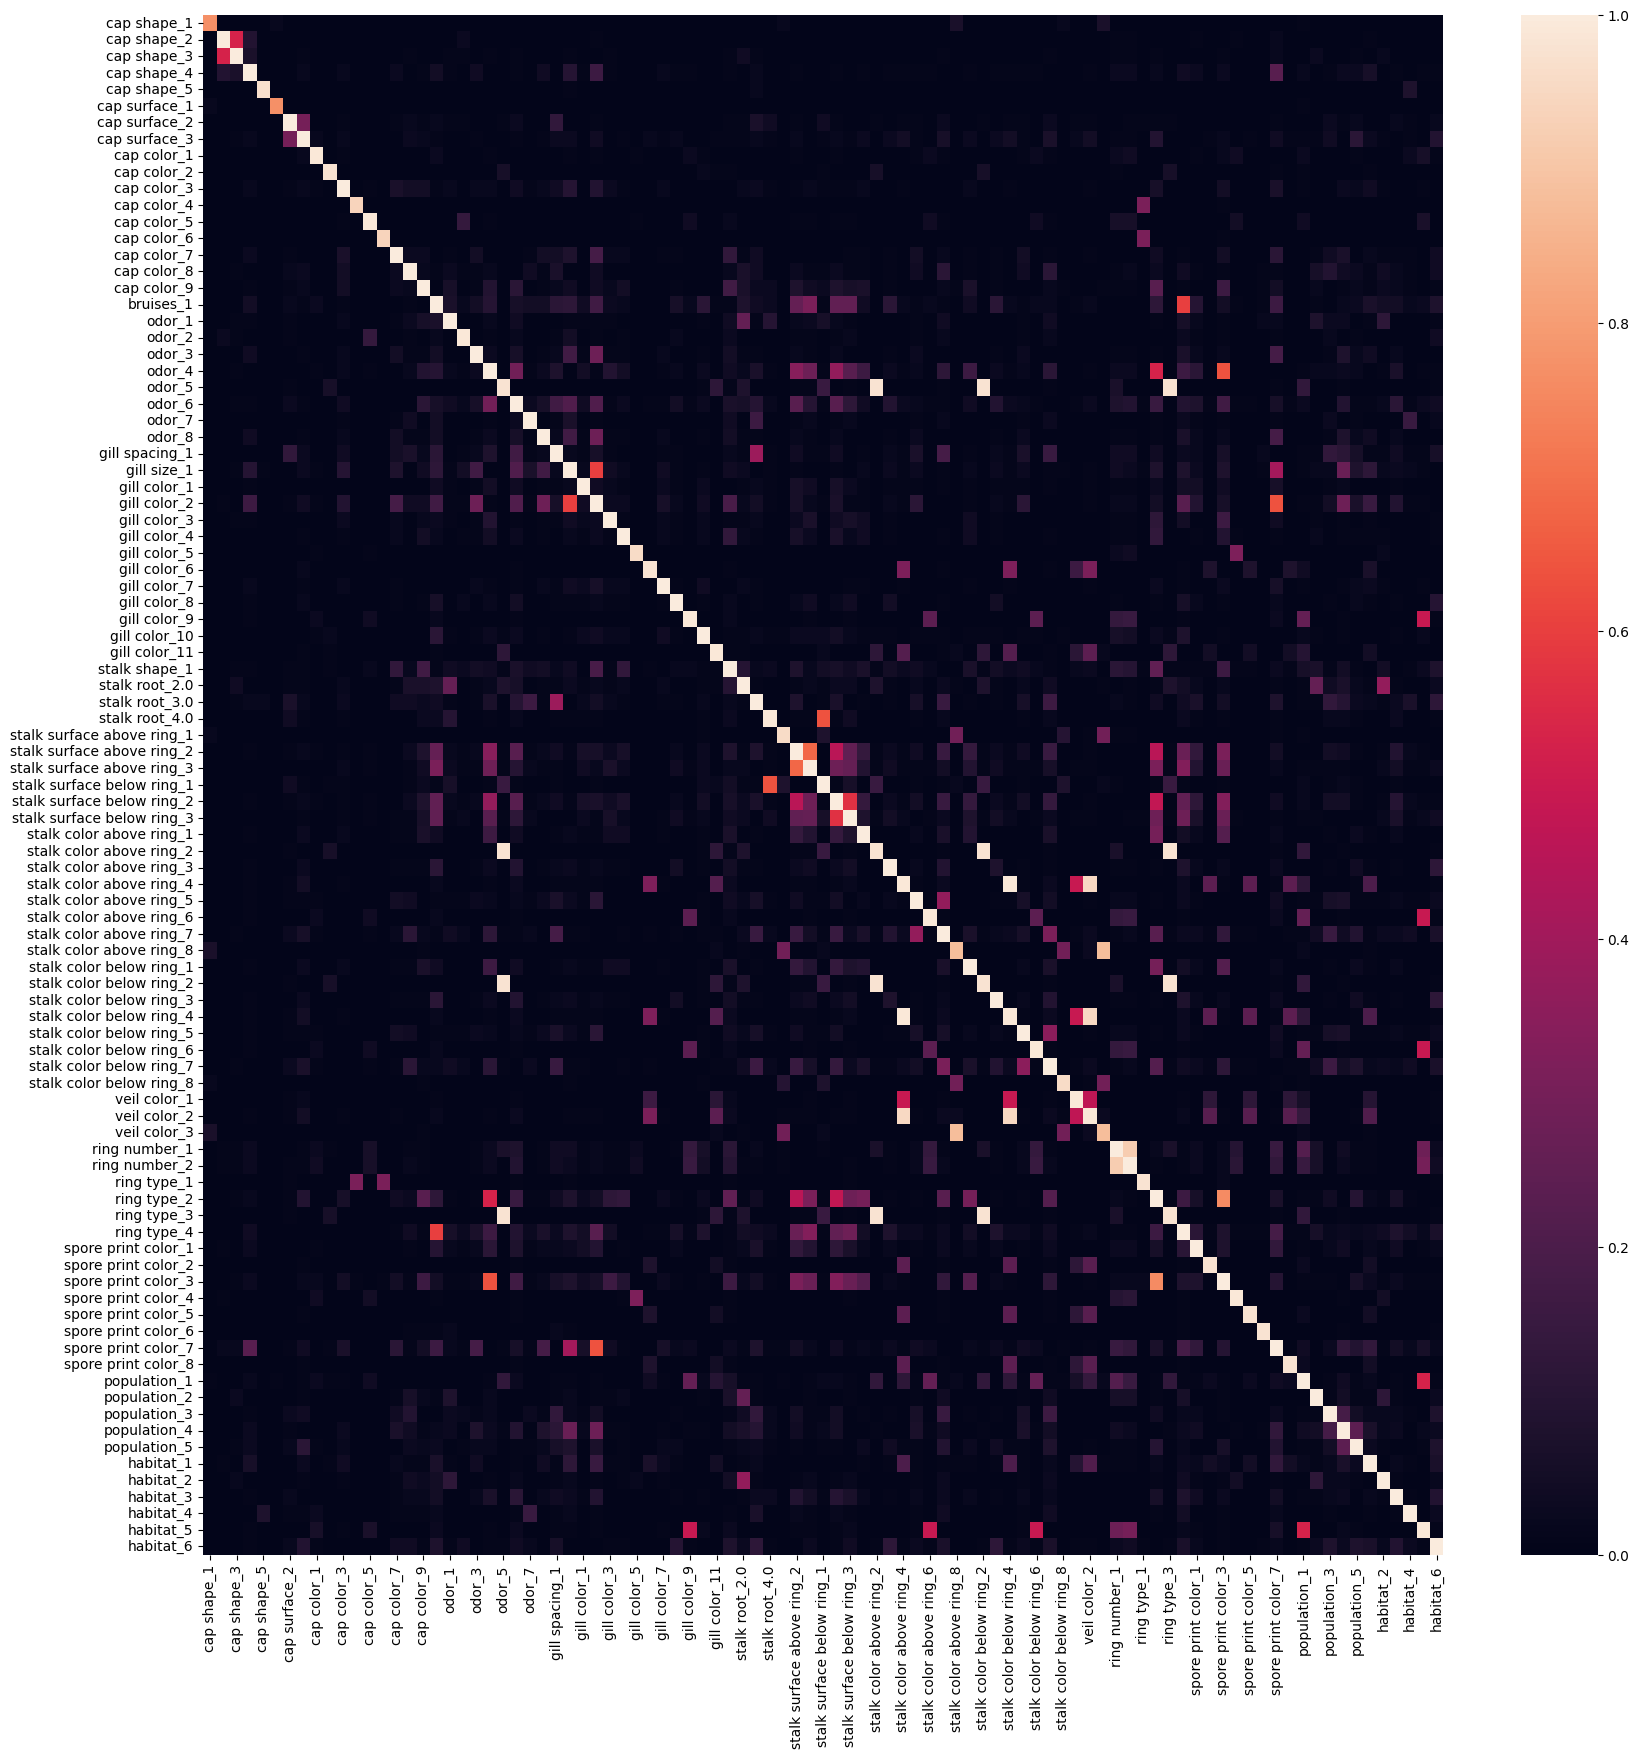

In [ ]:
rows= []

for var1 in X:
  col = []
  for var2 in X :
    cramers =cramers_V(X[var1], X[var2]) 
    col.append(round(cramers,2))  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = X.columns, index =X.columns)

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df, annot=False, fmt='0.3f')

Заметна сильная взаимосвязь между отдельными категориями в ring type, stalk color below ring, stalk color above ring, veil color, stalk root, gill color, odor. Судя по коэффициентаи V Крамера для небинаризованного датасета, можно удалить veil color и stalk root, stalk color below ring, stalk color above ring, ring type, потенциально сильно скоррелированные между собой и слабо скоррелированные с целевой меткой. Остальные переменные имеют отличные от нуля коэффициенты корреляции.

In [ ]:
data = pd.read_csv('./mushroom.csv', sep=';')
le = LabelEncoder()
for column in data.columns:
    data[column] = le.fit_transform(data[column]) 
data['stalk root'][data['stalk root'] == 0] = np.nan
data.fillna(data['stalk root'].median(), inplace=True)
data.drop(['veil type', 'gill attachment', 'veil color', 'stalk root', 'stalk color below ring', 'stalk color above ring', 'ring type'], axis=1, inplace=True)
columns = data.columns
columns = columns[1:]
for column in columns:
    data = data.join(pd.get_dummies(data[column], prefix=column, drop_first=True))
    data.drop(columns=column, inplace=True)

data

,type,cap shape_1,cap shape_2,cap shape_3,cap shape_4,cap shape_5,cap surface_1,cap surface_2,cap surface_3,cap color_1,...,population_2,population_3,population_4,population_5,habitat_1,habitat_2,habitat_3,habitat_4,habitat_5,habitat_6
0,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8411,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
8412,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
8413,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
8414,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0


In [ ]:
X = data.drop(['type'], axis=1)
y = data['type']

In [ ]:
X.shape

(8416, 67)

In [ ]:
matrix_rank(X)

67

Получили невырожденную матрицу. Попробуем вновь обучить логистическую регрессию.

In [ ]:
model = Logit(y, X)
result = model.fit()
result.summary()

         Current function value: 0.000002
         Iterations: 35


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   type   No. Observations:                 8416
Model:                          Logit   Df Residuals:                     8349
Method:                           MLE   Df Model:                           66
Date:                Fri, 21 Apr 2023   Pseudo R-squ.:                   1.000
Time:                        19:41:23   Log-Likelihood:              -0.020575
converged:                      False   LL-Null:                       -5814.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
cap shape_1                    3.8408   2460.459      0.002      0.999   -4818.570    4826.252
cap shape_2                   -0.6792     29.032     -0.023      0.981     -57.581      56.223
cap shape_3                   -0.5737     24.797     -0.023      0.982     -49.174      48.027
cap shape_4                   -0.8216     60.546     -0.014      0.989    -119.489     117.846
cap shape_5                   -0.9232   4.31e+04  -2.14e-05      1.000   -8.44e+04    8.44e+04
cap surface_1                  5.1639   7580.837      0.001      0.999   -1.49e+04    1.49e+04
cap surface_2                 -1.2927     58.256     -0.022      0.982    -115.472     112.887
cap surface_3                 -0.8567     57.734     -0.015      0.988    -114.013     112.300
cap color_1                   -5.6015    393.898     -0.014      0.989    -777.628     766.425
cap color_2                  -15.5043   2.38e+06  -6.52e-06      1.000   -4.66e+06    4.66e+06
cap color_3                   39.6971   1.67e+07   2.37e-06      1.000   -3.28e+07    3.28e+07
cap color_4                    7.1353   2.65e+04      0.000      1.000   -5.18e+04    5.19e+04
cap color_5                   11.0288   4.76e+04      0.000      1.000   -9.32e+04    9.32e+04
cap color_6                    7.1354   2.65e+04      0.000      1.000   -5.18e+04    5.19e+04
cap color_7                    1.0695   1.28e+04   8.33e-05      1.000   -2.52e+04    2.52e+04
cap color_8                   -6.5320    392.873     -0.017      0.987    -776.549     763.485
cap color_9                   -4.7510    309.298     -0.015      0.988    -610.964     601.462
bruises_1                    -17.8005   4.08e+05  -4.36e-05      1.000      -8e+05       8e+05
odor_1                         0.9301     84.353      0.011      0.991    -164.399     166.259
odor_2                        59.6248   2.69e+05      0.000      1.000   -5.28e+05    5.28e+05
odor_3                        69.3919   1.68e+07   4.14e-06      1.000   -3.28e+07    3.28e+07
odor_4                        69.8825   1.68e+07   4.17e-06      1.000   -3.28e+07    3.28e+07
odor_5                        -3.9960   1.69e+07  -2.36e-07      1.000   -3.32e+07    3.32e+07
odor_6                       -16.6357   1.67e+07  -9.94e-07      1.000   -3.28e+07    3.28e+07
odor_7                        54.1088   4.96e+05      0.000      1.000   -9.72e+05    9.72e+05
odor_8                        69.3919   1.68e+07   4.14e-06      1.000   -3.28e+07    3.28e+07
gill spacing_1               -10.9703   3.84e+05  -2.86e-05      1.000   -7.52e+05    7.52e+05
gill size_1                   43.9739   5.27e+05   8.35e-05      1.000   -1.03e+06    1.03e+06
gill color_1                  -2.1304   3798.189     -0.001      1.000   -7446.443    7442.182
gill color_2                 -46.5680   4.18e+05     -0.000      1.000   -8.19e+05    8.19e+05
gill color_3                  -3.4048   3798.052     -0.001      0.999   -7447.451    7440.641
gill color_

У признаков очень большие p-value, часто равные единице, отличны от 1 только p-value для некоторых из них (в statsmodels вроде как считается t-критерий?), что говорит о том, что мы не можем отвергнуть нулевую гипотезу об отсутствии взаимосвязи между признаком и целевой переменной. При этом псевдо-$R^2$ равен 1, и лог-правдоподобие близко к нулю (а максимизация правдоподобия эквивалентна оптимизации MSE). Судя по всему действительно предсказания по сути базируются лишь на нескольких признаках, и это несколько искажает зависимости в линейной модели. Также, согласно теории, либо среди признаков есть мультиколлинеарные, что отчасти видно по значениям корреляции V Крамера, либо что отдельные признаки плохо объясняеют целевую переменную, однако совокупный эффект значим, судя по всему за счет признака odor. В определенной степени можно сказать, что получилась в целом почти идеально предсказывающая целевую переменную модель. Однако матрица признаков после one-hot кодирования сильно разрежена, есть отдельные категории с почти вырожденным распределением. В следствие этого сложно оценить модель кросс-валидацией по фолдам, т. к. при разбиении выборки ее части вновь могут оказаться вырожденными.

Рассмотрим коэффициенты подробнее, отсортируем по убыванию модуля для удобства оценки их важности.

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
d = {'Feature': X.columns, 'Coefficient' : result.params}
res = pd.DataFrame(data=d)
res = res.reset_index()
res.drop(['index'], axis=1, inplace=True)
res.sort_values(by='Coefficient', key=abs, ascending=False)

,Feature,Coefficient
21,odor_4,69.882485
20,odor_3,69.391893
25,odor_8,69.391893
51,spore print color_4,66.118962
19,odor_2,59.624850
24,odor_7,54.108811
29,gill color_2,-46.568028
27,gill size_1,43.973876
10,cap color_3,39.697085
43,stalk surface below ring_1,32.689006


Признак odor имеет действительно высокие значения коэффициентов. С учетом предыдущих наблюдений можно предположить, что именно по нему можно строить идеальное разбиение выборки. Либо же в данных отсутствуют какие-либо зависимости.

Рассмотрим качество модели на тех же данных, на которых она обучалась.

In [ ]:
pred = model.predict(result.params, X, 'prob')
print(f"ROC AUC: {roc_auc_score(y, pred)}")
print(f"Accuracy: {accuracy_score(y, pred >= 0.5)}") 

ROC AUC: 1.0
Accuracy: 1.0


Получили идеальное качество.

Попробуем использовать обучающие и тестовые данные для оценки модели.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100500)

In [ ]:
m = Logit(y_train, X_train)
r = m.fit()
r.summary()

         Current function value: inf
         Iterations: 35


LinAlgError: ignored

Возникает упомянутая проблема, при разбиении часто фолды оказываются вырожденными, что затрудняет оценку модели.

Попробуем теперь удалить предиктор odor, посмотрим, как это скажется на качестве.

Вообще в целом матрица признаков получилась слишком разреженной после one-hot кодирования, поэтому можем рассмотреть распределения фиктивных признаков и отбросить признаки с категориями с вырождающимися категориями.

In [ ]:
X.mean().sort_values()

cap shape_1                   0.000475
cap surface_1                 0.000475
cap color_4                   0.001901
cap color_6                   0.001901
stalk surface above ring_1    0.002852
gill color_5                  0.002852
cap shape_5                   0.003802
cap color_2                   0.005228
spore print color_8           0.005703
spore print color_6           0.005703
spore print color_5           0.005703
spore print color_2           0.005703
odor_5                        0.005703
gill color_6                  0.007605
spore print color_4           0.008555
gill color_11                 0.010932
gill color_9                  0.011407
cap color_5                   0.017110
cap color_1                   0.019962
odor_2                        0.022814
habitat_5                     0.022814
odor_7                        0.030418
habitat_2                     0.034696
stalk surface below ring_1    0.035171
population_1                  0.041825
habitat_4                

Удалим odor и рассмотрим модель без него, также отсечем признаки с частотой единиц ниже 1 процента.

In [ ]:
data = pd.read_csv('./mushroom.csv', sep=';')
le = LabelEncoder()
for column in data.columns:
    data[column] = le.fit_transform(data[column]) 
data['stalk root'][data['stalk root'] == 0] = np.nan
data.fillna(data['stalk root'].median(), inplace=True)
data.drop(['veil type', 'gill attachment', 'veil color', 'stalk root', 'stalk color below ring', 'stalk color above ring', 'ring type',
           'cap shape', 'cap surface', 'cap color', 'stalk surface above ring', 'gill color', 'cap shape', 'spore print color', 'ring number', 'odor'], axis=1, inplace=True)
columns = data.columns
columns = columns[1:]
for column in columns:
    data = data.join(pd.get_dummies(data[column], prefix=column, drop_first=True))
    data.drop(columns=column, inplace=True)

data

,type,bruises_1,gill spacing_1,gill size_1,stalk shape_1,stalk surface below ring_1,stalk surface below ring_2,stalk surface below ring_3,population_1,population_2,population_3,population_4,population_5,habitat_1,habitat_2,habitat_3,habitat_4,habitat_5,habitat_6
0,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
1,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
2,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
3,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
4,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8411,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0
8412,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
8413,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0
8414,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0


In [ ]:
X = data.drop(['type'], axis=1)
y = data['type']

In [ ]:
model = Logit(y, X)
result = model.fit()
result.summary()

         Current function value: 0.169314
         Iterations: 35


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   type   No. Observations:                 8416
Model:                          Logit   Df Residuals:                     8398
Method:                           MLE   Df Model:                           17
Date:                Fri, 21 Apr 2023   Pseudo R-squ.:                  0.7549
Time:                        19:53:42   Log-Likelihood:                -1424.9
converged:                      False   LL-Null:                       -5814.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
bruises_1                     -0.3848      0.174     -2.211      0.027      -0.726      -0.044
gill spacing_1                -5.1764      0.196    -26.406      0.000      -5.561      -4.792
gill size_1                    6.3272      0.223     28.335      0.000       5.890       6.765
stalk shape_1                  1.9813      0.180     11.038      0.000       1.630       2.333
stalk surface below ring_1    -0.4925      0.288     -1.708      0.088      -1.058       0.073
stalk surface below ring_2     7.4975      0.335     22.384      0.000       6.841       8.154
stalk surface below ring_3    -1.2903      0.179     -7.223      0.000      -1.640      -0.940
population_1                   3.8295      0.377     10.162      0.000       3.091       4.568
population_2                 -25.3904   1.33e+04     -0.002      0.998    -2.6e+04     2.6e+04
population_3                  -0.7165      0.214     -3.343      0.001      -1.136      -0.296
population_4                  -0.5180      0.257     -2.016      0.044      -1.022      -0.014
population_5                  -3.3852      0.294    -11.515      0.000      -3.961      -2.809
habitat_1                     -3.3937      0.315    -10.786      0.000      -4.010      -2.777
habitat_2                      0.6928      0.249      2.784      0.005       0.205       1.181
habitat_3                     -0.4881      0.284     -1.720      0.085      -1.044       0.068
habitat_4                     -0.7561      0.210     -3.595      0.000      -1.168      -0.344
habitat_5                    -26.9431   1.44e+04     -0.002      0.999   -2.82e+04    2.81e+04
habitat_6                     -2.2125      0.180    -12.318      0.000      -2.565      -1.860
==============================================================================================

Possibly complete quasi-separation: A fraction 0.17 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Качество снизилось, снизился $R^2$ и лог-правдоподобие, но p-value признаков теперь в большинстве своем близки к нулю, есть два признака с почти единичными значениями. Таким образом, теперь целевая метка существенно зависит от многих признаков, а признаки с почти единичным p-value скорее всего действительно шумовые на фоне остальных.

Рассмотрим качество на тех же данных.

In [ ]:
pred = model.predict(result.params, X, 'prob')
print(f"ROC AUC: {roc_auc_score(y, pred)}")
print(f"Accuracy: {accuracy_score(y, pred >= 0.5)}") 

ROC AUC: 0.982476012067482
Accuracy: 0.9391634980988594


Качество снизилось, но в целом не сильно, и теперь можем спокойно работать с данными без возможности получения вырожленного фолда. Также по-видимому исходные признаки и так в целом были довольно хороши, даже без идеального предиктора они очень качественно моделируют задачу. Судя по всему в данных все же есть много относительно значимых зависимостей между целевой переменной и признаками.

Оценим модель при использовании обучающих и тестовых данных.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [ ]:
m = Logit(y_train, X_train)
r = model.fit()
r.summary()

         Current function value: 0.169314
         Iterations: 35


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   type   No. Observations:                 8416
Model:                          Logit   Df Residuals:                     8398
Method:                           MLE   Df Model:                           17
Date:                Fri, 21 Apr 2023   Pseudo R-squ.:                  0.7549
Time:                        19:56:25   Log-Likelihood:                -1424.9
converged:                      False   LL-Null:                       -5814.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
bruises_1                     -0.3848      0.174     -2.211      0.027      -0.726      -0.044
gill spacing_1                -5.1764      0.196    -26.406      0.000      -5.561      -4.792
gill size_1                    6.3272      0.223     28.335      0.000       5.890       6.765
stalk shape_1                  1.9813      0.180     11.038      0.000       1.630       2.333
stalk surface below ring_1    -0.4925      0.288     -1.708      0.088      -1.058       0.073
stalk surface below ring_2     7.4975      0.335     22.384      0.000       6.841       8.154
stalk surface below ring_3    -1.2903      0.179     -7.223      0.000      -1.640      -0.940
population_1                   3.8295      0.377     10.162      0.000       3.091       4.568
population_2                 -25.3904   1.33e+04     -0.002      0.998    -2.6e+04     2.6e+04
population_3                  -0.7165      0.214     -3.343      0.001      -1.136      -0.296
population_4                  -0.5180      0.257     -2.016      0.044      -1.022      -0.014
population_5                  -3.3852      0.294    -11.515      0.000      -3.961      -2.809
habitat_1                     -3.3937      0.315    -10.786      0.000      -4.010      -2.777
habitat_2                      0.6928      0.249      2.784      0.005       0.205       1.181
habitat_3                     -0.4881      0.284     -1.720      0.085      -1.044       0.068
habitat_4                     -0.7561      0.210     -3.595      0.000      -1.168      -0.344
habitat_5                    -26.9431   1.44e+04     -0.002      0.999   -2.82e+04    2.81e+04
habitat_6                     -2.2125      0.180    -12.318      0.000      -2.565      -1.860
==============================================================================================

Possibly complete quasi-separation: A fraction 0.17 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Оценим качество на тех же данных.

In [ ]:
p = m.predict(result.params, X_test, 'prob')
print(f"ROC AUC: {roc_auc_score(y_test, p)}")
print(f"Accuracy: {accuracy_score(y_test, p >= 0.5)}") 

ROC AUC: 0.980890692137341
Accuracy: 0.9330693069306931


Качество по-прежнему высокое.

Таким образом, полученная модель в целом выглядит адекватно и демонстрирует примеломое высокое качество. Также, судя по p-value, признаки стали существенно влиять на метку класса, т. е. отчасти модель стала понятнее и интерпретируемее, и нет проблем с разреженностью. 

Рассмотрим подробнее коэффициенты при признаках.

In [ ]:
d = {'Feature': X.columns, 'Coefficient' : result.params}
res = pd.DataFrame(data=d)
res = res.reset_index()
res.drop(['index'], axis=1, inplace=True)
res.sort_values(by='Coefficient', key=abs, ascending=False)

,Feature,Coefficient
16,habitat_5,-26.943137
8,population_2,-25.390442
5,stalk surface below ring_2,7.497457
2,gill size_1,6.327237
1,gill spacing_1,-5.176374
7,population_1,3.829493
12,habitat_1,-3.393746
11,population_5,-3.385171
17,habitat_6,-2.212516
3,stalk shape_1,1.981338


У фиктивных признаков с околоединичным p-value очень высокие значения коэффициентов регрессии. Сложно сразу сказать, важны ли они и существует ли зависимость целевой метки от них на самом деле. 

Попробуем удалить их, рассмотрим, как изменится качество.

In [ ]:
data = pd.read_csv('./mushroom.csv', sep=';')
le = LabelEncoder()
for column in data.columns:
    data[column] = le.fit_transform(data[column]) 
data['stalk root'][data['stalk root'] == 0] = np.nan
data.fillna(data['stalk root'].median(), inplace=True)
data.drop(['veil type', 'gill attachment', 'veil color', 'stalk root', 'stalk color below ring', 'stalk color above ring', 'ring type',
           'cap shape', 'cap surface', 'cap color', 'stalk surface above ring', 'gill color', 'cap shape', 'spore print color', 'ring number', 'odor',
           'population', 'habitat'], axis=1, inplace=True)
columns = data.columns
columns = columns[1:]
for column in columns:
    data = data.join(pd.get_dummies(data[column], prefix=column, drop_first=True))
    data.drop(columns=column, inplace=True)

data

,type,bruises_1,gill spacing_1,gill size_1,stalk shape_1,stalk surface below ring_1,stalk surface below ring_2,stalk surface below ring_3
0,0,0,1,1,1,0,0,1
1,0,0,1,1,1,0,0,1
2,0,0,1,1,1,0,0,1
3,0,0,1,1,1,0,0,1
4,0,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...
8411,0,1,0,0,0,0,0,1
8412,0,1,0,0,0,0,0,1
8413,0,1,0,0,0,0,0,1
8414,0,1,0,0,0,0,0,1


In [ ]:
X = data.drop(['type'], axis=1)
y = data['type']

In [ ]:
model = Logit(y, X)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.227608
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   type   No. Observations:                 8416
Model:                          Logit   Df Residuals:                     8409
Method:                           MLE   Df Model:                            6
Date:                Fri, 21 Apr 2023   Pseudo R-squ.:                  0.6706
Time:                        19:59:56   Log-Likelihood:                -1915.5
converged:                       True   LL-Null:                       -5814.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
bruises_1                     -0.0846      0.136     -0.624      0.533      -0.350       0.181
gill spacing_1                -4.3392      0.137    -31.590      0.000      -4.608      -4.070
gill size_1                    4.9610      0.146     34.035      0.000       4.675       5.247
stalk shape_1                  0.5917      0.093      6.353      0.000       0.409       0.774
stalk surface below ring_1    -1.2914      0.152     -8.482      0.000      -1.590      -0.993
stalk surface below ring_2     3.5061      0.185     18.930      0.000       3.143       3.869
stalk surface below ring_3    -2.6417      0.093    -28.322      0.000      -2.825      -2.459
==============================================================================================
"""

Качество снова снизилось, да и в целом модель теперь получилось очень простой. Оценим на тех же данных.

In [ ]:
pred = model.predict(result.params, X, 'prob')
print(f"ROC AUC: {roc_auc_score(y, pred)}")
print(f"Accuracy: {accuracy_score(y, pred >= 0.5)}") 

ROC AUC: 0.9534545164112673
Accuracy: 0.93393536121673


Качество снова снизилось, однако в целом оно все еще высоко. Видимо исходные признаки действительно хорошо описывают истинную зависимость. 

Оценим на обучающих и тестовых данных.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

m = Logit(y_train, X_train)
r = model.fit()
r.summary()

Optimization terminated successfully.
         Current function value: 0.227608
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   type   No. Observations:                 8416
Model:                          Logit   Df Residuals:                     8409
Method:                           MLE   Df Model:                            6
Date:                Fri, 21 Apr 2023   Pseudo R-squ.:                  0.6706
Time:                        20:02:05   Log-Likelihood:                -1915.5
converged:                       True   LL-Null:                       -5814.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
bruises_1                     -0.0846      0.136     -0.624      0.533      -0.350       0.181
gill spacing_1                -4.3392      0.137    -31.590      0.000      -4.608      -4.070
gill size_1                    4.9610      0.146     34.035      0.000       4.675       5.247
stalk shape_1                  0.5917      0.093      6.353      0.000       0.409       0.774
stalk surface below ring_1    -1.2914      0.152     -8.482      0.000      -1.590      -0.993
stalk surface below ring_2     3.5061      0.185     18.930      0.000       3.143       3.869
stalk surface below ring_3    -2.6417      0.093    -28.322      0.000      -2.825      -2.459
==============================================================================================
"""

In [ ]:
p = m.predict(result.params, X_test, 'prob')
print(f"ROC AUC: {roc_auc_score(y_test, p)}")
print(f"Accuracy: {accuracy_score(y_test, p >= 0.5)}") 

ROC AUC: 0.9545830954280593
Accuracy: 0.9310891089108911


Качество стало хуже, но не сильно, оно по прежнему высокое.

Таким образом, в данных есть один признак odor, по которому выборка идельно разбивается на классы. Однако строить линйеную модель с ним проблематично в силу проблем с вырожденностью. Также сложно в таком случае и интерпретировать признаки в силу больших p-value. Есть также признаки с почти вырожденным распределением категорий, что также усложняет построение модели вероятности класса. Можно строить модель и без них, тогда уходят проблемы с вырожденностью, проще интерпретировать признаки и оценивать их важность, качество при этом снижается, модель перестает быть идеальным классификатором, однако показатели качества остаются весьма высокими. Но все же признак odor является идеальным предсказателем, наиболее важным и сильным признакам. Наблюденные в данных зависимости согласуются с названием и смыслом признаков, логикой и зависимостями в действительности в подобных задачах.